In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%%capture
!pip install geopandas
!pip install country_converter

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import linregress
import glob
import json
import country_converter as coco
from datetime import datetime, timedelta
import requests
import geopandas as gpd



sns.set_context('poster')
custom_palette = ['#1b9e77','#7570b3','#d95f02']

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
base_path = '/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/figures/'

# Load 

In [6]:
df_all = pd.read_csv('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/final_results_complete.csv')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Bootstrap for confidence intervals

In [7]:
nboot = 1000
unique_titles = list(df_all['Title'].unique())

# initialize some bootstrap things
# Descriptive stats - overall, neurology, neuroscience, psychiatry sc rate
fa_recent_sc = np.zeros((nboot, 4))
la_recent_sc = np.zeros((nboot, 4))
any_recent_sc = np.zeros((nboot, 4))

# Figure 1 - over time
r_boot = np.zeros((nboot, 3))
m_boot = np.zeros((nboot, 3))
sc_rates = np.zeros((nboot, 21, 3))

# Figure 2 - academic ages, [age, sc rate]
s = df_all[df_all.Year.isin([2016, 2017, 2018, 2019, 2020])].ac_age.value_counts()  # s for set
ac_age_to_keep = np.sort(list(s[s>=100].index))
fa_ac_age_sc = np.zeros((nboot, len(ac_age_to_keep)))
la_ac_age_sc = np.zeros((nboot, len(ac_age_to_keep)))

# Figure 4 - topics
num_topics = 13
topic_assignments = pd.read_csv('/content/gdrive/MyDrive/MINDS_lab/self_citation/notebooks/topic_model/lda_results_' + str(num_topics) + '.csv')
topic_fa_sc = np.zeros((nboot, num_topics))
topic_la_sc = np.zeros((nboot, num_topics))
topic_any_sc = np.zeros((nboot, num_topics))

# Figure 5 - gender
perc_female_fa_la_topic = np.zeros((nboot, num_topics, 2))
topic_gender_sc_fa_female = np.zeros((nboot, num_topics))
topic_gender_sc_la_female = np.zeros((nboot, num_topics))
topic_gender_sc_fa_male = np.zeros((nboot, num_topics))
topic_gender_sc_la_male = np.zeros((nboot, num_topics))
time_gender_sc_fa_female = np.zeros((nboot, 21))  # 21 yrs
time_gender_sc_la_female = np.zeros((nboot, 21))  # 21 yrs
time_gender_sc_fa_male = np.zeros((nboot, 21))  # 21 yrs
time_gender_sc_la_male = np.zeros((nboot, 21))  # 21 yrs
time_gender_proportion_fa_female = np.zeros((nboot, 21))
time_gender_proportion_fa_male = np.zeros((nboot, 21))
time_gender_proportion_la_female = np.zeros((nboot, 21))
time_gender_proportion_la_male = np.zeros((nboot, 21))
ac_age_gender_sc_female = np.zeros((nboot, 51))  # academic ages 0-50
ac_age_gender_sc_male = np.zeros((nboot, 51))
num_papers_sc_female = []
num_papers_sc_male = []
num_papers_by_ac_age_female =[]; num_papers_by_ac_age_male = []
num_papers_groups = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500]
num_papers_sc_groups_female = np.zeros((nboot, len(num_papers_groups)))
num_papers_sc_groups_male = np.zeros((nboot, len(num_papers_groups)))

# Countries - specify which to keep
s = df_all[df_all['SC Type']=='FA']['affil_country'].value_counts()
fa_countries_to_keep = list(s[s>=50].index)
fa_countries_to_keep = [country for country in fa_countries_to_keep if country!='Error']
fa_countries_to_keep.sort()
s = df_all[df_all['SC Type']=='LA']['affil_country'].value_counts()
la_countries_to_keep = list(s[s>=50].index)
la_countries_to_keep = [country for country in la_countries_to_keep if country!='Error']
fa_sc_rate_country = np.zeros((nboot, len(fa_countries_to_keep)))
la_sc_rate_country = np.zeros((nboot, len(la_countries_to_keep)))
fa_numpapers_country = np.zeros((nboot, len(fa_countries_to_keep)))
la_numpapers_country = np.zeros((nboot, len(la_countries_to_keep)))
la_countries_to_keep.sort()

# main boostrap loop
for seed in tqdm(range(nboot)):

  # bootstrap on titles
  np.random.seed(seed)
  titles_boot = np.random.choice(unique_titles, size=len(unique_titles), replace=True)
  df_boot = df_all[df_all['Title'].isin(titles_boot)].reset_index()


  ########################### Descriptive stats (most recent year: 2020) ################################  
  fields = ['Neurology', 'Neuroscience', 'Psychiatry']
  # first for all fields
  df_recent = df_boot[(df_boot.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_boot['field'].isin(fields))]
  df_recent_summary = df_recent.groupby(['field', 'SC Type'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
  df_recent_summary['sc_rate'] = df_recent_summary['sc_count'] / df_recent_summary['numref']

  # for overall sc rates
  fa_recent_sc[seed, 0] = df_recent_summary[df_recent_summary['SC Type']=='FA']['sc_count'].sum() / df_recent_summary[df_recent_summary['SC Type']=='FA']['numref'].sum()
  la_recent_sc[seed, 0] = df_recent_summary[df_recent_summary['SC Type']=='LA']['sc_count'].sum() / df_recent_summary[df_recent_summary['SC Type']=='LA']['numref'].sum()
  any_recent_sc[seed, 0] = df_recent_summary[df_recent_summary['SC Type']=='Any']['sc_count'].sum() / df_recent_summary[df_recent_summary['SC Type']=='Any']['numref'].sum()

  # rates by field
  for i, field in enumerate(fields):
    fa_recent_sc[seed, i+1] = df_recent_summary[(df_recent_summary.field==field) & (df_recent_summary['SC Type']=='FA')]['sc_rate']
    la_recent_sc[seed, i+1] = df_recent_summary[(df_recent_summary.field==field) & (df_recent_summary['SC Type']=='LA')]['sc_rate']
    any_recent_sc[seed, i+1] = df_recent_summary[(df_recent_summary.field==field) & (df_recent_summary['SC Type']=='Any')]['sc_rate']


  ########################### SC Over time ###################################
  df_year_sum_all = df_boot.groupby(["Year", "SC Type"]).agg({"numref": "sum", "sc_count":"sum"})
  df_year_sum_all['sc_rate'] = df_year_sum_all['sc_count'] / df_year_sum_all['numref']
  df_year_sum_all = df_year_sum_all.sort_values('Year').reset_index()
  df_year_sum_all

  # assign self-citation rates over time
  sc_rates[seed, :, 0] = df_year_sum_all[df_year_sum_all['SC Type']=='FA']['sc_rate']
  sc_rates[seed, :, 1] = df_year_sum_all[df_year_sum_all['SC Type']=='LA']['sc_rate']
  sc_rates[seed, :, 2] = df_year_sum_all[df_year_sum_all['SC Type']=='Any']['sc_rate']

  # calculate correlation (and slope) between year and self-citation rates
  for auth_idx, auth_type in enumerate(['FA', 'LA', 'Any']):
    df_tmp = df_year_sum_all[df_year_sum_all['SC Type']==auth_type]
    r_boot[seed, auth_idx] = df_tmp['sc_rate'].corr(df_tmp['Year']) 
    regr = linregress(df_tmp['Year'], df_tmp['sc_rate'])
    m_boot[seed, auth_idx] = regr.slope

  ########################### academic age (include only last 5 years: 2016-2020) ###################################
  df_ac_age = df_boot[(df_boot.Year.isin([2016, 2017, 2018, 2019, 2020]))  & (df_boot.ac_age.isin(ac_age_to_keep))]
  df_ac_age_summary = df_ac_age.groupby(['SC Type', 'ac_age']).agg({"numref": "sum", "sc_count":"sum", "numpapers":"sum"})
  df_ac_age_summary = df_ac_age_summary.sort_values('ac_age').reset_index()
  df_ac_age_summary['sc_rate'] = df_ac_age_summary['sc_count'] / df_ac_age_summary['numref']
  fa_ac_age_sc[seed, :] = df_ac_age_summary[df_ac_age_summary['SC Type']=='FA']['sc_rate']
  la_ac_age_sc[seed, :] = df_ac_age_summary[df_ac_age_summary['SC Type']=='LA']['sc_rate']



  ########################### Topics (include only last 5 years: 2016-2020) ###################################

  df_topics = df_boot[df_boot['Year'].isin([2016, 2017, 2018, 2019, 2020])].reset_index(drop=True)
  df_topics = df_topics[df_topics['topic']!='Error']

  df_topic_grouped = df_topics.groupby(["topic", "SC Type"]).agg({"numref": "sum", "sc_count":"sum"}).reset_index()
  df_topic_grouped['sc_rate'] = df_topic_grouped['sc_count'] / df_topic_grouped['numref']
  df_topic_grouped['topic'] = [int(t) for t in df_topic_grouped.topic]
  df_topic_grouped = df_topic_grouped.sort_values('topic')

  topic_fa_sc[seed, :] = df_topic_grouped[df_topic_grouped['SC Type']=='FA']['sc_rate']
  topic_la_sc[seed, :] = df_topic_grouped[df_topic_grouped['SC Type']=='LA']['sc_rate']
  topic_any_sc[seed, :] = df_topic_grouped[df_topic_grouped['SC Type']=='Any']['sc_rate']

  
  ########################### Gender (first part: 2000-2020, second part: last 5 years only) ###################################
  # assign percentage authorship by year
  df1 = df_boot.groupby(["SC Type", "Year"]).agg({"numpapers":"sum"}).reset_index()
  df2 = df_boot.groupby(["SC Type", "gender_binary", "Year"]).agg({"numpapers":"sum", "numref":"sum", "sc_count":"sum"}).reset_index()
  df2 = df2[df2['gender_binary']!='Error']
  df_gender_year_summary = df1.merge(df2, left_on=["SC Type", "Year"], right_on=["SC Type", "Year"])
  df_gender_year_summary = df_gender_year_summary.rename(columns={"numpapers_x":"total_papers", "numpapers_y":"gender_papers"}, errors="raise")
  df_gender_year_summary['perc_gender'] = df_gender_year_summary['gender_papers'] / df_gender_year_summary['total_papers']
  df_gender_year_summary['sc_rate'] = df_gender_year_summary['sc_count'] / df_gender_year_summary['numref']
  df_gender_year_summary = df_gender_year_summary.sort_values(by='Year')
  time_gender_proportion_fa_female[seed, :] = df_gender_year_summary[(df_gender_year_summary['SC Type']=='FA') & (df_gender_year_summary['gender_binary']=='Female')]['perc_gender']
  time_gender_proportion_la_female[seed, :] = df_gender_year_summary[(df_gender_year_summary['SC Type']=='LA') & (df_gender_year_summary['gender_binary']=='Female')]['perc_gender']
  time_gender_proportion_fa_male[seed, :] = df_gender_year_summary[(df_gender_year_summary['SC Type']=='FA') & (df_gender_year_summary['gender_binary']=='Male')]['perc_gender']
  time_gender_proportion_la_male[seed, :] = df_gender_year_summary[(df_gender_year_summary['SC Type']=='LA') & (df_gender_year_summary['gender_binary']=='Male')]['perc_gender']

  # Now gender by topic (df_topics only includes 2016-2020)
  df_topics = df_topics[df_topics.gender_probs!='Error']
  df_topics = df_topics[df_topics.gender_binary!='Error']

  df1 = df_topics.groupby(["SC Type", "topic"]).agg({"numpapers":"sum"}).reset_index()
  df2 = df_topics.groupby(["SC Type", "topic", "gender_binary"]).agg({"numpapers":"sum", "numref":"sum", "sc_count":"sum"}).reset_index()
  df_gender_topic_summary = df1.merge(df2, left_on=["SC Type", "topic"], right_on=["SC Type", "topic"])
  df_gender_topic_summary = df_gender_topic_summary.rename(columns={"numpapers_x":"total_papers", "numpapers_y":"gender_papers"}, errors="raise")
  df_gender_topic_summary['perc_gender'] = df_gender_topic_summary['gender_papers'] / df_gender_topic_summary['total_papers']
  df_gender_topic_summary['sc_rate'] = df_gender_topic_summary['sc_count'] / df_gender_topic_summary['numref']
  df_gender_topic_summary = df_gender_topic_summary.sort_values(by=['topic'])  # must sort by topic for array assignment in next steps

  # assign percentage authorship by topic
  perc_female_fa_la_topic[seed, :, 0] = df_gender_topic_summary[(df_gender_topic_summary['SC Type']=='FA') & (df_gender_topic_summary['gender_binary']=='Female')]['perc_gender']
  perc_female_fa_la_topic[seed, :, 1] = df_gender_topic_summary[(df_gender_topic_summary['SC Type']=='LA') & (df_gender_topic_summary['gender_binary']=='Female')]['perc_gender']


  # assign SC rates
  topic_gender_sc_fa_female[seed, :] = df_gender_topic_summary[(df_gender_topic_summary['SC Type']=='FA') & 
                                                               (df_gender_topic_summary['gender_binary']=='Female')]['sc_rate']
  topic_gender_sc_la_female[seed, :] = df_gender_topic_summary[(df_gender_topic_summary['SC Type']=='LA') & 
                                                               (df_gender_topic_summary['gender_binary']=='Female')]['sc_rate']
  topic_gender_sc_fa_male[seed, :] = df_gender_topic_summary[(df_gender_topic_summary['SC Type']=='FA') & 
                                                               (df_gender_topic_summary['gender_binary']=='Male')]['sc_rate']
  topic_gender_sc_la_male[seed, :] = df_gender_topic_summary[(df_gender_topic_summary['SC Type']=='LA') & 
                                                               (df_gender_topic_summary['gender_binary']=='Male')]['sc_rate'] 
  


  # now gender over years
  # make groupings by year
  df_boot_gender = df_boot[df_boot.gender_binary!='Error']
  df1 = df_boot_gender.groupby(["Year", "SC Type"]).agg({"numpapers":"sum"}).reset_index()
  df2 = df_boot_gender.groupby(["Year", "SC Type", "gender_binary"]).agg({"numpapers":"sum", "numref":"sum", "sc_count":"sum"}).reset_index()
  df_gender_summary = df1.merge(df2, left_on=["Year", "SC Type"], right_on=["Year", "SC Type"])
  df_gender_summary = df_gender_summary.rename(columns={"numpapers_x":"total_papers", "numpapers_y":"gender_papers"}, errors="raise")
  df_gender_summary['perc_gender'] = df_gender_summary['gender_papers'] / df_gender_summary['total_papers']
  df_gender_summary['sc_rate'] = df_gender_summary['sc_count'] / df_gender_summary['numref']
  df_gender_summary = df_gender_summary.sort_values(by=['gender_binary'])
  df_gender_summary = df_gender_summary[df_gender_summary['gender_binary']!='Error']
  # now save years for each gender / author order combo
  time_gender_sc_fa_female[seed, :] = df_gender_summary[(df_gender_summary['SC Type']=='FA') & (df_gender_summary['gender_binary']=='Female')].sort_values(by=['Year'])['sc_rate']
  time_gender_sc_la_female[seed, :] = df_gender_summary[(df_gender_summary['SC Type']=='LA') & (df_gender_summary['gender_binary']=='Female')].sort_values(by=['Year'])['sc_rate']
  time_gender_sc_fa_male[seed, :] = df_gender_summary[(df_gender_summary['SC Type']=='FA') & (df_gender_summary['gender_binary']=='Male')].sort_values(by=['Year'])['sc_rate']
  time_gender_sc_la_male[seed, :] = df_gender_summary[(df_gender_summary['SC Type']=='LA') & (df_gender_summary['gender_binary']=='Male')].sort_values(by=['Year'])['sc_rate']
  
  # now gender by academic age (include only 2016-2020) 
  df_tmp = df_boot_gender[ df_boot_gender.Year.isin([2016, 2017, 2018, 2019, 2020]) & df_boot_gender.ac_age.isin(ac_age_to_keep) ]
  df_ac_age_gender_summary = df_tmp.groupby(['ac_age', 'gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum', 'numpapers':'sum', 'papers_before_by_date':'mean'})
  df_ac_age_gender_summary['sc_rate'] = df_ac_age_gender_summary['sc_count'] / df_ac_age_gender_summary['numref']
  ac_age_gender_sc_female[seed, :] = df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Female']['sc_rate']
  ac_age_gender_sc_male[seed, :] = df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Male']['sc_rate']

  # self-citation by number of papers (include only 2016-2020)
  df_sc_numpapers = df_boot[ (df_boot.gender_binary!='Error') & (df_boot.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_boot.ac_age.isin(ac_age_to_keep))]
  df_papers_sc_summary = df_sc_numpapers.groupby(['papers_before_by_date', 'gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
  df_papers_sc_summary['sc_rate'] = df_papers_sc_summary['sc_count'] / df_papers_sc_summary['numref']
  df_papers_sc_summary = df_papers_sc_summary.sort_values('papers_before_by_date')
  tmp_zip = zip(df_papers_sc_summary[df_papers_sc_summary.gender_binary=='Female']['papers_before_by_date'], df_papers_sc_summary[df_papers_sc_summary.gender_binary=='Female']['sc_rate'])
  tmp_zip = list(tmp_zip)
  num_papers_sc_female.append(tmp_zip)
  tmp_zip = zip(df_papers_sc_summary[df_papers_sc_summary.gender_binary=='Male']['papers_before_by_date'], df_papers_sc_summary[df_papers_sc_summary.gender_binary=='Male']['sc_rate'])
  tmp_zip = list(tmp_zip)
  num_papers_sc_male.append(tmp_zip)

  # number of papers by academic age (include only 2016-2020)
  df_sc_numpapers = df_boot[ (df_boot.gender_binary!='Error') & (df_boot.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_boot.ac_age.isin(ac_age_to_keep))]
  df_papers_ac_age_summary = df_sc_numpapers.groupby(['ac_age', 'gender_binary'], as_index=False).agg({'papers_before_by_date':'mean', 'numpapers':'sum'})
  df_papers_ac_age_summary = df_papers_ac_age_summary.sort_values('ac_age')
  tmp_zip = zip(df_papers_ac_age_summary[df_papers_ac_age_summary.gender_binary=='Female']['ac_age'], df_papers_ac_age_summary[df_papers_ac_age_summary.gender_binary=='Female']['papers_before_by_date'])
  tmp_zip = list(tmp_zip)
  num_papers_by_ac_age_female.append(tmp_zip)
  tmp_zip = zip(df_papers_ac_age_summary[df_papers_ac_age_summary.gender_binary=='Male']['ac_age'], df_papers_ac_age_summary[df_papers_ac_age_summary.gender_binary=='Male']['papers_before_by_date'])
  tmp_zip = list(tmp_zip)
  num_papers_by_ac_age_male.append(tmp_zip)  

  # also grouping number of papers by ranges
  df_sc_numpapers['papers_before_category'] = df_sc_numpapers['papers_before_by_date'].replace({range(0, 10):0, range(10, 20):10, range(20, 30):20, range(30, 40):30, range(40, 50):40,
                                                                                              range(50, 60):50,  range(60, 70):60, range(70, 80):70, range(80, 90):80, range(90, 100):90, 
                                                                                              range(100, 150):100, range(150, 200):150, range(200, 250):200, range(250, 300):250, 
                                                                                              range(300, 400):300, range(400, 500):400, range(500, 10000):500})
  df_sc_numpapers_group_summary = df_sc_numpapers.groupby(['papers_before_category', 'gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'}).sort_values('papers_before_category')
  df_sc_numpapers_group_summary['sc_rate'] = df_sc_numpapers_group_summary.sc_count / df_sc_numpapers_group_summary.numref
  num_papers_sc_groups_female[seed, :] = df_sc_numpapers_group_summary[df_sc_numpapers_group_summary.gender_binary=='Female']['sc_rate']
  num_papers_sc_groups_male[seed, :] = df_sc_numpapers_group_summary[df_sc_numpapers_group_summary.gender_binary=='Male']['sc_rate']

  ########################### Countries, includes only 2016-2020 ###################################
  df_countries = df_boot[(df_boot.affil_country.isin(fa_countries_to_keep)) & (df_boot['SC Type']=='FA')]  # keep first author data with countries
  df_countries = df_countries.append(df_boot[(df_boot.affil_country.isin(la_countries_to_keep)) & (df_boot['SC Type']=='LA')])  # add in last author data with countries
  df_country_summary = df_countries.groupby(["SC Type", 'affil_country']).agg({"numref": "sum", "fa": "sum", "la": "sum", "fa_la": "sum", "any": "sum", "numpapers":"sum"}).reset_index()
  df_country_summary['sum_perc_fa'] = df_country_summary['fa'] / df_country_summary['numref']
  df_country_summary['sum_perc_la'] = df_country_summary['la'] / df_country_summary['numref']
  df_country_summary['sum_perc_any'] = df_country_summary['any'] / df_country_summary['numref']
  df_country_summary = df_country_summary.sort_values(by=['affil_country'], ascending=True)

  fa_sc_rate_country[seed, :] = df_country_summary[df_country_summary['SC Type']=='FA'].sum_perc_fa
  la_sc_rate_country[seed, :] = df_country_summary[df_country_summary['SC Type']=='LA'].sum_perc_la 
  fa_numpapers_country[seed, :] = df_country_summary[df_country_summary['SC Type']=='FA'].numpapers
  la_numpapers_country[seed, :] = df_country_summary[df_country_summary['SC Type']=='LA'].numpapers

########################### Save ###################################
np.savez('save_path.npz', 
         fa_recent_sc=fa_recent_sc, la_recent_sc=la_recent_sc, any_recent_sc=any_recent_sc,
         r_boot=r_boot, m_boot=m_boot, sc_rates=sc_rates,
         ac_age_to_keep=ac_age_to_keep, fa_ac_age_sc=fa_ac_age_sc, la_ac_age_sc=la_ac_age_sc,
         topic_fa_sc=topic_fa_sc, topic_la_sc=topic_la_sc, topic_any_sc=topic_any_sc,
         perc_female_fa_la_topic=perc_female_fa_la_topic, topic_gender_sc_fa_female=topic_gender_sc_fa_female,
         topic_gender_sc_la_female=topic_gender_sc_la_female, topic_gender_sc_fa_male=topic_gender_sc_fa_male,
         topic_gender_sc_la_male=topic_gender_sc_la_male,
         time_gender_sc_fa_female=time_gender_sc_fa_female, time_gender_sc_la_female=time_gender_sc_la_female,
         time_gender_sc_fa_male=time_gender_sc_fa_male, time_gender_sc_la_male=time_gender_sc_la_male,
         ac_age_gender_sc_female=ac_age_gender_sc_female, ac_age_gender_sc_male=ac_age_gender_sc_male, 
         time_gender_proportion_fa_female=time_gender_proportion_fa_female, time_gender_proportion_la_female=time_gender_proportion_la_female,
         time_gender_proportion_fa_male=time_gender_proportion_fa_male, time_gender_proportion_la_male=time_gender_proportion_la_male,
         fa_countries_to_keep=fa_countries_to_keep, la_countries_to_keep=la_countries_to_keep, fa_sc_rate_country=fa_sc_rate_country, 
         la_sc_rate_country=la_sc_rate_country, fa_numpapers_country=fa_numpapers_country, la_numpapers_country=la_numpapers_country,
         num_papers_sc_female=num_papers_sc_female, num_papers_sc_male=num_papers_sc_male,
         num_papers_by_ac_age_male=num_papers_by_ac_age_male, num_papers_by_ac_age_female=num_papers_by_ac_age_female,
         num_papers_groups=num_papers_groups, num_papers_sc_groups_female=num_papers_sc_groups_female, num_papers_sc_groups_male=num_papers_sc_groups_male,
         allow_pickle=True)



  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-7-88c3ea1603e4>:228: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sc_numpapers['papers_before_category'] = df_sc_numpapers['papers_before_by_date'].replace({range(0, 10):0, range(10, 20):10, range(20, 30):20, range(30, 40):30, range(40, 50):40,
100%|██████████| 1000/1000 [39:37<00:00,  2.38s/it]
/usr/local/lib/python3.8/dist-packages/numpy/lib/npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


# Load boot results

In [8]:
dat = np.load('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/bootstrap_results/boot_results.npz', allow_pickle=True)
dat['r_boot']

array([[-0.98111256,  0.12857711,  0.71984385],
       [-0.97234322, -0.00421398,  0.62889304],
       [-0.97150037,  0.10065298,  0.76079027],
       ...,
       [-0.97350213, -0.1213076 ,  0.69212924],
       [-0.97162646,  0.0835392 ,  0.73708555],
       [-0.97333791,  0.03107396,  0.66700202]])

# Descriptive stats

In [9]:
fa_recent_sc = dat['fa_recent_sc']
la_recent_sc = dat['la_recent_sc']
any_recent_sc = dat['any_recent_sc']

# summarize data frame
fields = ['All', 'Neurology', 'Neuroscience', 'Psychiatry']

for i, field in enumerate(fields):

  print(field + ': First author: ' + '{:.6f}'.format(np.mean(fa_recent_sc[:, i])) + \
        ' (' + '{:.6f}'.format(np.percentile(fa_recent_sc[:, i], q=2.5)) + ', ' + '{:.6f}'.format(np.percentile(fa_recent_sc[:, i], q=97.5)) + ')' + \
        '; Last author: ' +  '{:.6f}'.format(np.mean(la_recent_sc[:, i])) + \
        ' (' + '{:.6f}'.format(np.percentile(la_recent_sc[:, i], q=2.5)) + ', ' + '{:.6f}'.format(np.percentile(la_recent_sc[:, i], q=97.5)) + ')' + \
        '; Any author: '  +  '{:.6f}'.format(np.mean(any_recent_sc[:, i])) + \
        ' (' + '{:.6f}'.format(np.percentile(any_recent_sc[:, i], q=2.5)) + ', ' + '{:.6f}'.format(np.percentile(any_recent_sc[:, i], q=97.5)) + ')' )

  # print('P value for first vs last difference: ' + '{:.5f}'.format(1-np.mean((la_recent_sc[:, 1] - fa_recent_sc[:, 1])>0)))

All: First author: 0.044982 (0.044421, 0.045609); Last author: 0.079540 (0.078904, 0.080198); Any author: 0.144237 (0.143022, 0.145344)
Neurology: First author: 0.049048 (0.048029, 0.050000); Last author: 0.090624 (0.089436, 0.091836); Any author: 0.173763 (0.171749, 0.175750)
Neuroscience: First author: 0.035286 (0.034321, 0.036217); Last author: 0.065957 (0.064827, 0.067016); Any author: 0.106528 (0.104849, 0.108015)
Psychiatry: First author: 0.052773 (0.051806, 0.053747); Last author: 0.084167 (0.083041, 0.085298); Any author: 0.158532 (0.156909, 0.160290)


# Figure 1 - 2020 and over years

## histogram

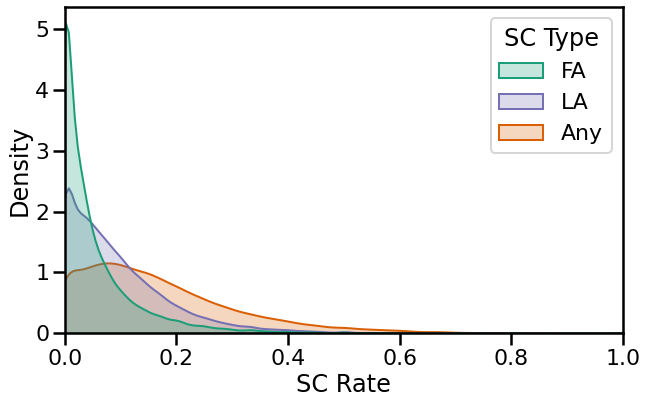

In [10]:
save_figs=True
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10, 6)) 
sns.kdeplot(data=df_all[df_all.Year.isin([2016, 2017, 2018, 2019, 2020])], x='SC Rate', hue='SC Type', fill=True, ax=ax, palette=custom_palette[:3])
ax.set_xlim(0, 1)
if save_figs:
  fig.savefig(base_path + 'fig1_time_hist/last5yrs_distribution.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')


## over time

In [11]:
# r values
print('****r values****')
print(np.mean(dat['r_boot'], axis=0))
print(np.percentile(dat['r_boot'], q=2.5, axis=0))
print(np.percentile(dat['r_boot'], q=97.5, axis=0))

# m values
print('****m values****')
print(np.mean(dat['m_boot'], axis=0))
print(np.percentile(dat['m_boot'], q=2.5, axis=0))
print(np.percentile(dat['m_boot'], q=97.5, axis=0))

****r values****
[-0.97750371  0.04476839  0.74429419]
[-0.98694454 -0.13629214  0.64846004]
[-0.9673902   0.22114004  0.82225817]
****m values****
[-1.05267535e-03  1.70434077e-05  5.38446069e-04]
[-1.11245278e-03 -4.83928519e-05  4.33695609e-04]
[-9.96692586e-04  8.57849729e-05  6.44022641e-04]


In [12]:
print('********Year 2000********')
print(np.mean(dat['sc_rates'][:, 0, :], axis=0))
print(np.percentile(dat['sc_rates'][:, 0, :], q=2.5, axis=0))
print(np.percentile(dat['sc_rates'][:, 0, :], q=97.5, axis=0))

print('********Year 2020********')
print(np.mean(dat['sc_rates'][:, -1, :], axis=0))
print(np.percentile(dat['sc_rates'][:, -1, :], q=2.5, axis=0))
print(np.percentile(dat['sc_rates'][:, -1, :], q=97.5, axis=0))


********Year 2000********
[0.06535096 0.07886077 0.13888216]
[0.06328748 0.07668705 0.13560414]
[0.06754248 0.08103354 0.14247209]
********Year 2020********
[0.04177218 0.07679313 0.14056118]
[0.04065956 0.07534398 0.13822879]
[0.0428794  0.07822287 0.14282754]


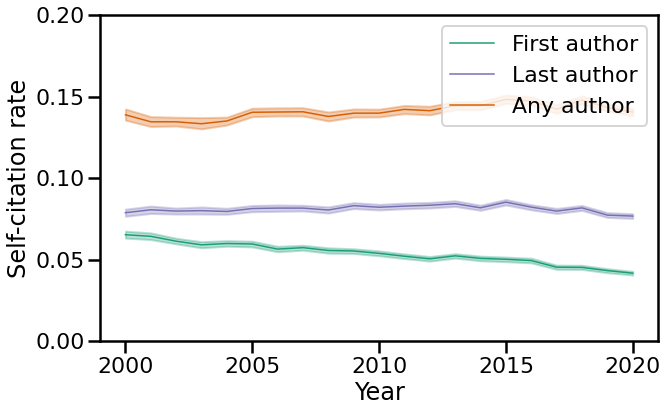

In [13]:
save_figs=True
sns.set_context('poster')
ordering = ['First author', 'Last author', 'Any author']
years = np.arange(2000, 2021)
fig, ax = plt.subplots(figsize=(10, 6)) 
colors = custom_palette[:3]
sc_rates_time = dat['sc_rates']

for i, sc_type in enumerate(ordering):
  sc_time_iter = np.mean(sc_rates_time[:, :, i], axis=0)  # either first, last or any
  sc_lower = np.percentile(sc_rates_time[:, :, i], q=2.5, axis=0)
  sc_upper = np.percentile(sc_rates_time[:, :, i], q=97.5, axis=0)

  ax.plot(years, sc_time_iter, label=sc_type, color=custom_palette[i], linewidth=1.5)
  ax.fill_between(years, sc_lower, sc_upper, color=custom_palette[i], alpha=.3)

ax.set_xticks([2000, 2005, 2010, 2015, 2020])
ax.set_ylim([0, 0.2])
ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax.set_xlabel('Year')
ax.set_ylabel('Self-citation rate')
plt.legend()

if save_figs:
  fig.savefig(base_path + 'fig1_time_hist/over_time.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')


Convert r to p values

In [14]:
import scipy
r1, r2, r3 = np.median(dat['r_boot'], axis=0)
N=21
for r in [r1, r2, r3]:
  t =	r  / np.sqrt((1-r**2)/(N-2))
  pval = 2*scipy.stats.t.sf(abs(t), N-2)
  print('pvalue: ' + str(pval))

pvalue: 2.6431918004687266e-14
pvalue: 0.8476694563033746
pvalue: 0.00010236054932368681


# Figure 2 - Academic Age

## for first or last auth

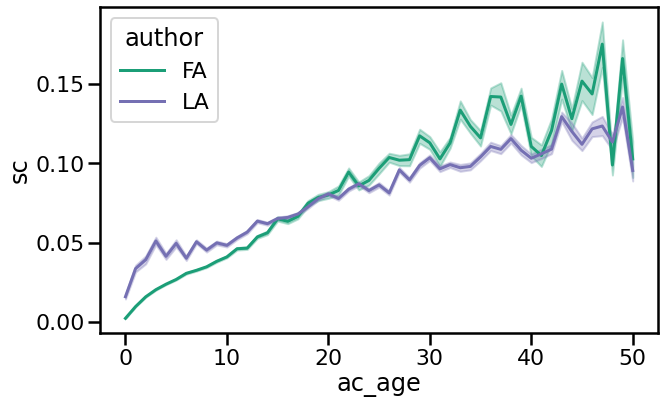

In [15]:
save_figs = True
# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.25)
def qupper(x):
    return x.quantile(0.75)

# sum used to turn into one large list (dat contains list of lists)
fa_ac_age = np.sort(dat['ac_age_to_keep'])
fa_ac_age_sc = dat['fa_ac_age_sc']
nboot = np.shape(fa_ac_age_sc)[0]

la_ac_age = np.sort(dat['ac_age_to_keep'])
la_ac_age_sc = dat['la_ac_age_sc']

ac_age = np.tile(fa_ac_age, 2*nboot)
ac_age_sc = np.hstack((fa_ac_age_sc.ravel(), la_ac_age_sc.ravel()))

author_type = ['FA']*len(fa_ac_age_sc.ravel()) + ['LA']*len(la_ac_age_sc.ravel())

df_ac_age = pd.DataFrame(list(zip(ac_age, ac_age_sc, author_type)),
               columns =['ac_age', 'sc', 'author'])

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(data=df_ac_age, x='ac_age', y='sc', ci=None, hue='author', palette=custom_palette[:2])

# find 95% CI with 2.5, 97.5% quantile
df_quantiles=df_ac_age[df_ac_age.author=='FA'].groupby(['ac_age']).agg({'sc': [qlower, qupper]})
ax.fill_between(df_quantiles.index, df_quantiles['sc']['qlower'], df_quantiles['sc']['qupper'], color=custom_palette[0], alpha=.3)

df_quantiles=df_ac_age[df_ac_age.author=='LA'].groupby(['ac_age']).agg({'sc': [qlower, qupper]})
ax.fill_between(df_quantiles.index, df_quantiles['sc']['qlower'], df_quantiles['sc']['qupper'], color=custom_palette[1], alpha=.3)

if save_figs:
  fig.savefig(base_path + 'fig2_ac_age/academic_age.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')


In [16]:
# print out actual numbers
a = df_ac_age.groupby(['author', 'ac_age'], as_index=False).agg({'sc':'mean'})
a[a.ac_age.isin(np.arange(0, 31, 5))]

,author,ac_age,sc
0,FA,0.0,0.002550
5,FA,5.0,0.027009
10,FA,10.0,0.041206
15,FA,15.0,0.065196
20,FA,20.0,0.080186
25,FA,25.0,0.096937
30,FA,30.0,0.112975
51,LA,0.0,0.016139
56,LA,5.0,0.049703
61,LA,10.0,0.048483


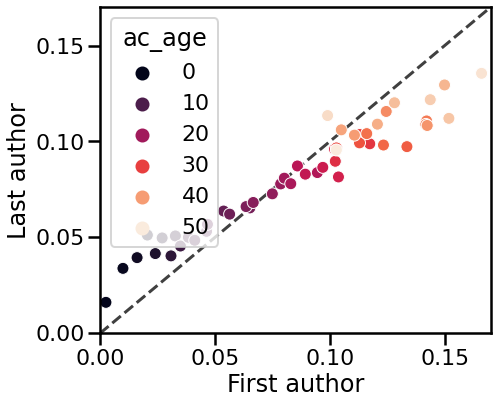

In [17]:
df_ac_age_fa = df_ac_age[df_ac_age['author']=='FA'].groupby('ac_age', as_index=False).agg({'sc':'mean'})
df_ac_age_la = df_ac_age[df_ac_age['author']=='LA'].groupby('ac_age', as_index=False).agg({'sc':'mean'})

df_ac_age_fa_vs_la = df_ac_age_fa.merge(df_ac_age_la, left_on='ac_age', right_on='ac_age')

fig, ax = plt.subplots(figsize=(7, 6))
sns.scatterplot(data=df_ac_age_fa_vs_la, x='sc_x', y='sc_y', ci=None, ax=ax, hue='ac_age', palette = "rocket")
ax.set_xlabel('First author')
ax.set_ylabel('Last author')
ax.set_xlim([0, 0.17])
ax.set_ylim([0, 0.17])
ax.set_xticks([0, 0.05, 0.1, 0.15])
ax.set_yticks([0, 0.05, 0.1, 0.15])

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)

if save_figs:
  fig.savefig(base_path + 'fig2_ac_age/academic_age_fa_vs_la.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')


# Figure 3 - Country

In [18]:
# show dataframe for first authors
auth_type = 'la'
df_tmp = pd.DataFrame({'country':dat[auth_type+'_countries_to_keep'], 'sc_mean':np.mean(dat[auth_type+'_sc_rate_country'], axis=0),
              'sc_lower': np.percentile(dat[auth_type+'_sc_rate_country'], axis=0, q=2.5), 'sc_upper': np.percentile(dat[auth_type+'_sc_rate_country'], axis=0, q=97.5)})
df_tmp.to_csv('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/figures/fig3_country/' + auth_type + '_data.csv')

In [19]:
with open('/content/gdrive/MyDrive/MINDS_lab/self_citation/affil_data/country_names.txt') as f:
    country_list = f.read().splitlines()

In [20]:
# load in affiliation data
all_files = glob.glob('/content/gdrive/MyDrive/MINDS_lab/self_citation/affil_data/*.csv')
fa_affils = []
la_affils = []
titles = []
err=0
tot_papers = 0
for file in tqdm(all_files):
  err_file = 0
  # print(file)
  df = pd.read_csv(file)
  npapers = df.shape[0]
  tot_papers+=npapers
  for i in range(npapers):
    try:
      affil_data = df['Affiliations'][i].split(';')
      fa_affil_str = affil_data[0]
      la_affil_str = affil_data[-1]

      
      fa_affil_tmp = [country_tmp for country_tmp in country_list if country_tmp in fa_affil_str]
      la_affil_tmp = [country_tmp for country_tmp in country_list if country_tmp in la_affil_str]

      if len(fa_affil_tmp)==1 and len(la_affil_tmp)==1:
        fa_affils.extend(fa_affil_tmp)
        la_affils.extend(la_affil_tmp)
        titles.append(df['Title'][i])

      elif len(fa_affil_tmp)>2 or len(la_affil_tmp)>2:
        print('Check number ' + str(i))
    except:
      # print(df.loc[i])
      err+=1
      err_file+=1
    
  # print(err_file)

print('Number missing / errors: ' + str(err), ' out of ' + str(tot_papers) + ' papers')

 87%|████████▋ | 55/63 [00:21<00:02,  2.78it/s]/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3,5,6,7,10,11,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,2

Number missing / errors: 945  out of 43852 papers


In [21]:
la_affil_dict = {titles[i]: la_affils[i] for i in range(len(la_affils))}
fa_affil_dict = {titles[i]: fa_affils[i] for i in range(len(fa_affils))}

In [22]:
import pickle
with open('/content/gdrive/MyDrive/MINDS_lab/self_citation/affil_data/fa_affil_dict.pkl', 'wb') as f:
    pickle.dump(fa_affil_dict, f)

with open('/content/gdrive/MyDrive/MINDS_lab/self_citation/affil_data/la_affil_dict.pkl', 'wb') as f:
    pickle.dump(la_affil_dict, f)    


In [23]:
df_affil = df_all[df_all['Year'].isin([2016, 2017, 2018, 2019, 2020])].reset_index()
print(df_affil.shape)

(124023, 51)


In [24]:
titles_unique = set()
for x in titles:
    titles_unique.add(x)
print('Length of titles: {:d}, unique titles: {:d}'.format(len(titles), len(titles_unique)))

Length of titles: 39560, unique titles: 39542


In [25]:
affil_country = []
for i in tqdm(range(df_affil.shape[0])):

  if df_affil['Title'][i] in la_affil_dict:
    if df_affil['SC Type'][i] == 'FA':
      affil_country.append(fa_affil_dict[df_affil.Title[i]])
    elif df_affil['SC Type'][i] == 'LA':
      affil_country.append(la_affil_dict[df_affil.Title[i]])
    elif df_affil['SC Type'][i] == 'Any':  # for Any auth self-cites look at LA country
          affil_country.append(la_affil_dict[df_affil.Title[i]])
  else:
    affil_country.append('Error')

df_affil['country'] = affil_country

100%|██████████| 124023/124023 [00:03<00:00, 39314.37it/s]


In [26]:
df_affil['numpapers'] = [1]*len(df_affil)
df_country_summary = df_affil.groupby(["SC Type", 'country']).agg({"numref": "sum", "fa": "sum", "la": "sum", "fa_la": "sum", "any": "sum", "numpapers":"sum"}).reset_index()
df_country_summary['sum_perc_fa'] = df_country_summary['fa'] / df_country_summary['numref']
df_country_summary['sum_perc_la'] = df_country_summary['la'] / df_country_summary['numref']
df_country_summary['sum_perc_any'] = df_country_summary['any'] / df_country_summary['numref']

In [27]:
%%capture
!pip install geopandas
!pip install country_converter

In [28]:
import json
import country_converter as coco
from datetime import datetime, timedelta
import requests
import geopandas as gpd


In [30]:
paper_thresh = 50  # exclude countries with fewer than 50 papers
df_country_summary = df_country_summary[df_country_summary.country!='Error']
df_country_summary = df_country_summary[df_country_summary.numpapers>paper_thresh]
df_country_summary['iso_a3'] = coco.convert(names=list(df_country_summary.country), to='ISO3', not_found='NULL')


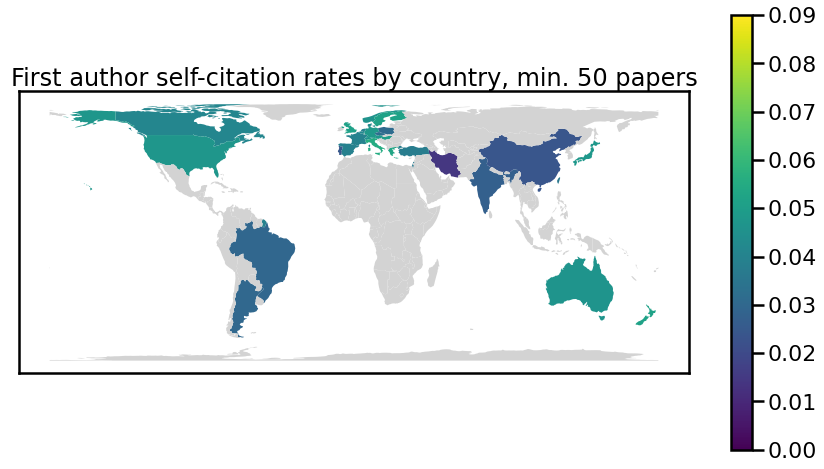

In [31]:
save_figs = True
plot_type = 'FA'  # RUN FOR FA AND LA
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name=='France', 'iso_a3'] = 'FRA'  # fix france error where iso_a3 is excluded
df_plot = df_country_summary[df_country_summary['SC Type']==plot_type]
world = world.merge(df_plot, how='left', left_on=['iso_a3'], right_on=['iso_a3'])
fig, ax = plt.subplots(figsize=(15, 8))
world = world.to_crs(epsg=6933)
world.plot(column='sum_perc_' + plot_type.lower(), ax=ax, legend=True, missing_kwds={'color': 'lightgrey'}, cmap='viridis', vmin=0, vmax=0.09)
ax.set_xticks([]); ax.set_yticks([])

if plot_type=='FA':
  title_str = 'First author'
elif plot_type=='LA':
  title_str = 'Last author'
elif plot_type=='Any':
  title_str = 'Any author'

ax.set_title(title_str + ' self-citation rates by country, min. ' + str(paper_thresh) + ' papers', fontsize=24)
if save_figs:
  fig.savefig(base_path + 'fig3_country/map_' + plot_type + '.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')

# Figure 4 - topics

In [32]:
save_figs=False

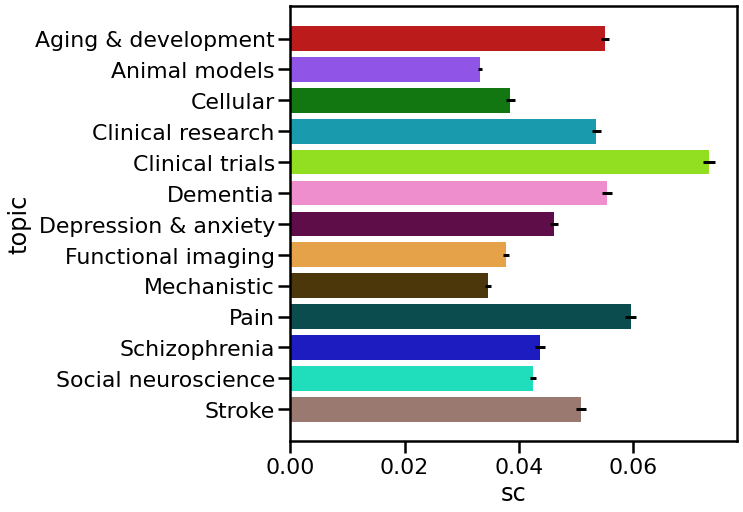

In [33]:
author_type = 'FA'
num_topics = 13
from seaborn.utils import ci
import colorcet as cc

# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.25)
def qupper(x):
    return x.quantile(0.75)

topic_fa_sc=dat['topic_fa_sc']
topic_la_sc=dat['topic_la_sc']
topic_any_sc=dat['topic_any_sc']

topic_names = np.array(['Clinical research', 'Aging & development', 'Dementia', 'Functional imaging',
               'Pain', 'Animal models', 'Stroke', 'Clinical trials', 'Schizophrenia', 'Cellular', 
               'Mechanistic', 'Depression & anxiety', 'Social neuroscience'])
alphabetical_order = np.argsort(topic_names)
ntopics = len(topic_names)

topic_sc_array = np.array([])
auth_array = np.array([])
topic_id_array = np.array([])
num_boot_iters = np.shape(topic_fa_sc)[0]
for i in range(ntopics):
  topic_sc_array = np.concatenate([topic_sc_array, topic_fa_sc[:, i], topic_la_sc[:, i], topic_any_sc[:, i]])
  auth_array = np.concatenate([auth_array, num_boot_iters*['FA'], num_boot_iters*['LA'], num_boot_iters*['Any']])
  # topic_id_array = np.concatenate([topic_id_array, 3*num_boot_iters*[i]])
  topic_id_array = np.concatenate([topic_id_array, 3*num_boot_iters*[topic_names[i]]])

df_topics = pd.DataFrame({'topic':topic_id_array, 'auth':auth_array, 'sc':topic_sc_array})
df_topics = df_topics.sort_values('topic')

fig, ax = plt.subplots(figsize=(8, 8))
many_palette = sns.color_palette(cc.glasbey, n_colors=num_topics)
sns.barplot(data=df_topics[df_topics['auth']==author_type], y='topic', x='sc', ci=None, orient='h', ax=ax, palette=many_palette)

# get quantiles for CI, then add error bars
df_quantiles = df_topics[df_topics.auth==author_type].groupby(['topic']).agg({'sc': [qlower, qupper]})
df_mean = df_topics[df_topics.auth==author_type].groupby(['topic']).agg({'sc': 'mean'})
ci_vals = np.zeros((2, 13))
ci_vals[0, :] = np.abs(df_quantiles['sc']['qlower'] - df_mean['sc'])
ci_vals[1, :] = df_quantiles['sc']['qupper'] - df_mean['sc']
ax.errorbar(x=df_mean.sc, y=np.arange(0, 13), xerr=ci_vals, ls='', lw=3, color='black')


if save_figs:
  fig.savefig(base_path + 'fig4_topics/topics_' + str(num_topics) + '_' + author_type + '.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')

In [34]:
df_mean

,sc
topic,
Aging & development,0.055152
Animal models,0.033217
Cellular,0.038519
Clinical research,0.053593
Clinical trials,0.073351
Dementia,0.055490
Depression & anxiety,0.046237
Functional imaging,0.037733
Mechanistic,0.034600


In [35]:
df_quantiles

sc          
                        qlower    qupper
topic                                   
Aging & development   0.054466  0.055876
Animal models         0.032807  0.033601
Cellular              0.037753  0.039308
Clinical research     0.052771  0.054427
Clinical trials       0.072272  0.074443
Dementia              0.054638  0.056404
Depression & anxiety  0.045544  0.046942
Functional imaging    0.037224  0.038253
Mechanistic           0.034077  0.035108
Pain                  0.058651  0.060560
Schizophrenia         0.042917  0.044645
Social neuroscience   0.041944  0.043067
Stroke                0.050077  0.051753

## topic and gender

In [37]:
def lighten_color(color, amount=0.5):
  """
  From: https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib
  Lightens the given color by multiplying (1-luminosity) by the given amount.
  Input can be matplotlib color string, hex string, or RGB tuple.

  Examples:
  >> lighten_color('g', 0.3)
  >> lighten_color('#F034A3', 0.6)
  >> lighten_color((.3,.55,.1), 0.5)
  """
  import matplotlib.colors as mc
  import colorsys
  try:
      c = mc.cnames[color]
  except:
      c = color
  c = colorsys.rgb_to_hls(*mc.to_rgb(c))
  return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

(2, 26)


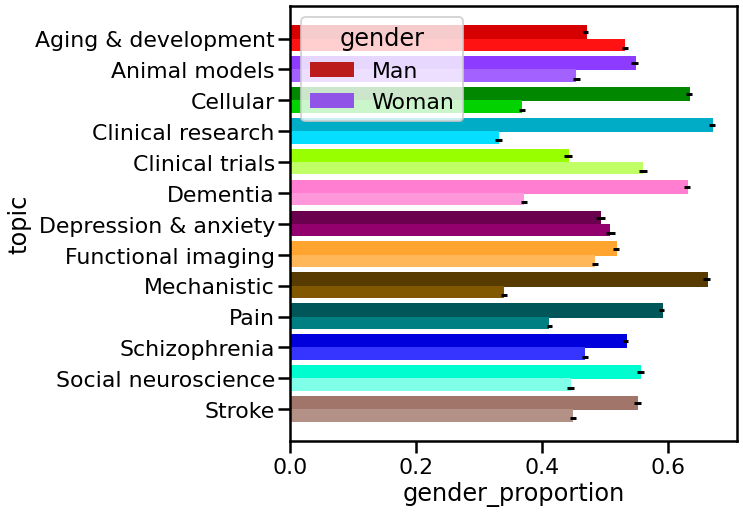

In [38]:
# Makes plot of gender proportions
author_type = 'FA'
num_topics = 13
from seaborn.utils import ci
import colorcet as cc

# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.25)
def qupper(x):
    return x.quantile(0.75)

topic_fa_proportion_female=dat['perc_female_fa_la_topic'][:, :, 0]
topic_la_proportion_female=dat['perc_female_fa_la_topic'][:, :, 1]
topic_fa_proportion_male=1-topic_fa_proportion_female
topic_la_proportion_male=1-topic_la_proportion_female


topic_names = np.array(['Clinical research', 'Aging & development', 'Dementia', 'Functional imaging',
               'Pain', 'Animal models', 'Stroke', 'Clinical trials', 'Schizophrenia', 'Cellular', 
               'Mechanistic', 'Depression & anxiety', 'Social neuroscience'])
alphabetical_order = np.argsort(topic_names)
ntopics = len(topic_names)

topic_proportion_array = np.array([])
auth_array = np.array([])
gender_array = np.array([])
topic_id_array = np.array([])
num_boot_iters = np.shape(topic_fa_sc)[0]
for i in range(ntopics):
  topic_proportion_array = np.concatenate([topic_proportion_array, topic_fa_proportion_female[:, i], topic_fa_proportion_male[:, i],
                                   topic_la_proportion_female[:, i], topic_la_proportion_male[:, i]])
  auth_array = np.concatenate([auth_array, num_boot_iters*['FA'], num_boot_iters*['FA'], num_boot_iters*['LA'], num_boot_iters*['LA']])
  gender_array = np.concatenate([gender_array, num_boot_iters*['Woman'], num_boot_iters*['Man'], num_boot_iters*['Woman'], num_boot_iters*['Man']])
  topic_id_array = np.concatenate([topic_id_array, 4*num_boot_iters*[topic_names[i]]])

df_topics = pd.DataFrame({'topic':topic_id_array, 'auth':auth_array, 'gender':gender_array, 'gender_proportion':topic_proportion_array})
df_topics = df_topics.sort_values('topic')

fig, ax = plt.subplots(figsize=(8, 8))
many_palette = sns.color_palette(cc.glasbey, n_colors=num_topics)
sns.barplot(data=df_topics[df_topics['auth']==author_type], y='topic', x='gender_proportion', hue='gender', ci=None, orient='h', ax=ax, palette=many_palette)

# make lighter palette
lighter_palette = sns.color_palette(cc.glasbey, n_colors=num_topics)
lighten_amounts = [0.8, 0.8, 0.8, 0.8, 0.6, 0.8, 0.9, 0.8, 0.9, 0.9, 0.7, 0.5, 0.8]
for i in range(len(many_palette)):
  lighter_palette[i] = lighten_color(many_palette[i], amount=lighten_amounts[i])

for i, bar in enumerate(ax.patches):
  if i>=num_topics:
    palette_idx = i-num_topics
    bar.set_facecolor(lighter_palette[palette_idx])
    # bar.set_hatch('\\')
  else:
    palette_idx = i
    bar.set_color(many_palette[palette_idx])


df_quantiles = df_topics[df_topics.auth==author_type].groupby(['topic', 'gender'], as_index=False).agg({'gender_proportion': [qlower, qupper]})
df_mean = df_topics[df_topics.auth==author_type].groupby(['topic', 'gender'], as_index=False).agg({'gender_proportion': 'mean'})
ci_vals = np.zeros((2, 2*num_topics))
ci_vals[0, :] = np.abs(df_quantiles['gender_proportion']['qlower'] - df_mean['gender_proportion'])
ci_vals[1, :] = df_quantiles['gender_proportion']['qupper'] - df_mean['gender_proportion']

print(np.shape(ci_vals))
ax.errorbar(x=df_mean.gender_proportion, y=np.arange(-.2, num_topics-.2, .5), xerr=ci_vals, ls='', lw=3, color='black')


if save_figs:
  fig.savefig(base_path + 'fig6_topic_gender/gender_topics_' + str(num_topics) + '_' + author_type + '.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')

(2, 26)


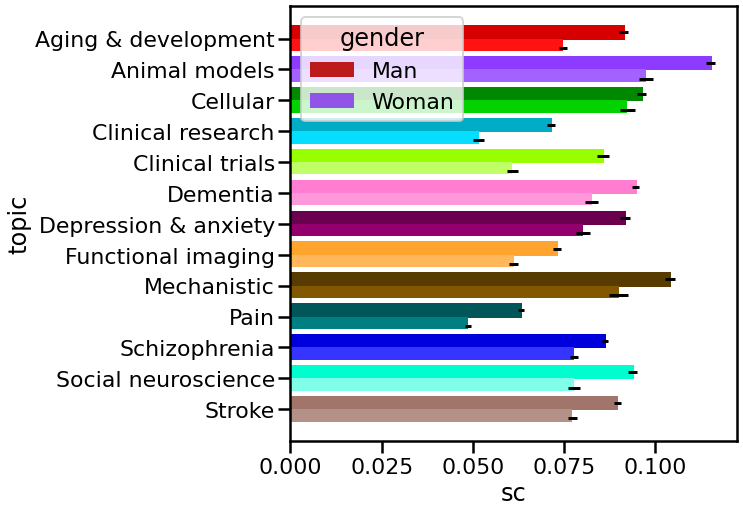

In [39]:
# Makes plots of self-citation by gender
author_type = 'LA'
num_topics = 13
from seaborn.utils import ci
import colorcet as cc

# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.25)
def qupper(x):
    return x.quantile(0.75)

dat['topic_gender_sc_fa_female']

topic_fa_sc_female=dat['topic_gender_sc_fa_female']
topic_la_sc_female=dat['topic_gender_sc_la_female']
topic_fa_sc_male=dat['topic_gender_sc_fa_male']
topic_la_sc_male=dat['topic_gender_sc_la_male']



topic_names = np.array(['Clinical research', 'Aging & development', 'Dementia', 'Functional imaging',
               'Pain', 'Animal models', 'Stroke', 'Clinical trials', 'Schizophrenia', 'Cellular', 
               'Mechanistic', 'Depression & anxiety', 'Social neuroscience'])
alphabetical_order = np.argsort(topic_names)
ntopics = len(topic_names)

topic_sc_array = np.array([])
auth_array = np.array([])
gender_array = np.array([])
topic_id_array = np.array([])
num_boot_iters = np.shape(topic_fa_sc)[0]
for i in range(ntopics):
  topic_sc_array = np.concatenate([topic_sc_array, topic_fa_sc_female[:, i], topic_fa_sc_male[:, i],
                                   topic_la_sc_female[:, i], topic_la_sc_male[:, i]])
  auth_array = np.concatenate([auth_array, num_boot_iters*['FA'], num_boot_iters*['FA'], num_boot_iters*['LA'], num_boot_iters*['LA']])
  gender_array = np.concatenate([gender_array, num_boot_iters*['Woman'], num_boot_iters*['Man'], num_boot_iters*['Woman'], num_boot_iters*['Man']])
  topic_id_array = np.concatenate([topic_id_array, 4*num_boot_iters*[topic_names[i]]])

df_topics = pd.DataFrame({'topic':topic_id_array, 'auth':auth_array, 'gender':gender_array, 'sc':topic_sc_array})
df_topics = df_topics.sort_values('topic')

fig, ax = plt.subplots(figsize=(8, 8))
many_palette = sns.color_palette(cc.glasbey, n_colors=num_topics)
sns.barplot(data=df_topics[df_topics['auth']==author_type], y='topic', x='sc', hue='gender', ci=None, orient='h', ax=ax, palette=many_palette)

# make lighter palette
lighter_palette = sns.color_palette(cc.glasbey, n_colors=num_topics)
lighten_amounts = [0.8, 0.8, 0.8, 0.8, 0.6, 0.8, 0.9, 0.8, 0.9, 0.9, 0.7, 0.5, 0.8]
for i in range(len(many_palette)):
  lighter_palette[i] = lighten_color(many_palette[i], amount=lighten_amounts[i])

for i, bar in enumerate(ax.patches):
  if i>=num_topics:
    palette_idx = i-num_topics
    bar.set_facecolor(lighter_palette[palette_idx])
    # bar.set_hatch('\\')
  else:
    palette_idx = i
    bar.set_color(many_palette[palette_idx])


df_quantiles = df_topics[df_topics.auth==author_type].groupby(['topic', 'gender'], as_index=False).agg({'sc': [qlower, qupper]})
df_mean = df_topics[df_topics.auth==author_type].groupby(['topic', 'gender'], as_index=False).agg({'sc': 'mean'})
ci_vals = np.zeros((2, 2*num_topics))
ci_vals[0, :] = np.abs(df_quantiles['sc']['qlower'] - df_mean['sc'])
ci_vals[1, :] = df_quantiles['sc']['qupper'] - df_mean['sc']

print(np.shape(ci_vals))
ax.errorbar(x=df_mean.sc, y=np.arange(-.2, num_topics-.2, .5), xerr=ci_vals, ls='', lw=3, color='black')


if save_figs:
  fig.savefig(base_path + 'fig6_topic_gender/sc_gender_topics_' + str(num_topics) + '_' + author_type + '.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')

# Figure 5 - gender

In [40]:
# BOOT RESULTS: compare sc rates for men/women
print('Male FA sc in 2020: ' + '{:.6f}'.format(np.mean(dat['time_gender_sc_fa_male'][:, -1])) +
      ' (' + '{:.6f}'.format(np.percentile(dat['time_gender_sc_fa_male'][:, -1], q=2.5)) + ', '
      '{:.6f}'.format(np.percentile(dat['time_gender_sc_fa_male'][:, -1], q=97.5)) + ')')
print('Female FA sc in 2020: ' + '{:.6f}'.format(np.mean(dat['time_gender_sc_fa_female'][:, -1])) +
      ' (' + '{:.6f}'.format(np.percentile(dat['time_gender_sc_fa_female'][:, -1], q=2.5)) + ', '
      '{:.6f}'.format(np.percentile(dat['time_gender_sc_fa_female'][:, -1], q=97.5)) + ')')
# print(calc_pval(dat['time_gender_sc_fa_male'][:, -1], dat['time_gender_sc_fa_female'][:, -1]))


print('Male LA sc in 2020: ' + '{:.6f}'.format(np.mean(dat['time_gender_sc_la_male'][:, -1])) +
      ' (' + '{:.6f}'.format(np.percentile(dat['time_gender_sc_la_male'][:, -1], q=2.5)) + ', '
      '{:.6f}'.format(np.percentile(dat['time_gender_sc_la_male'][:, -1], q=97.5)) + ')')
print('Female LA sc in 2020: ' + '{:.6f}'.format(np.mean(dat['time_gender_sc_la_female'][:, -1])) +
      ' (' + '{:.6f}'.format(np.percentile(dat['time_gender_sc_la_female'][:, -1], q=2.5)) + ', '
      '{:.6f}'.format(np.percentile(dat['time_gender_sc_la_female'][:, -1], q=97.5)) + ')')
# print(calc_pval(dat['time_gender_sc_la_male'][:, -1], dat['time_gender_sc_la_female'][:, -1]))


Male FA sc in 2020: 0.051232 (0.049314, 0.053050)
Female FA sc in 2020: 0.033347 (0.031912, 0.034848)
Male LA sc in 2020: 0.081770 (0.079917, 0.083718)
Female LA sc in 2020: 0.067966 (0.065557, 0.070414)


## time author proportion

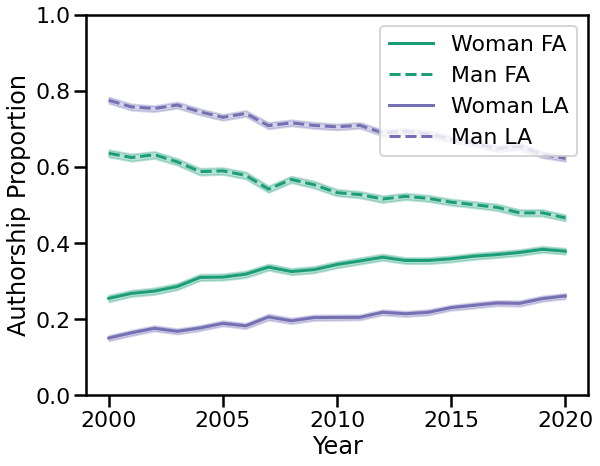

In [41]:
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

fa_gender_ratio = dat['time_gender_sc_fa_male'] / dat['time_gender_sc_fa_female']
fa_lower = np.percentile(dat['time_gender_proportion_fa_female'], q=2.5, axis=0)
fa_upper = np.percentile(fa_gender_ratio, q=97.5, axis=0)

la_gender_ratio = dat['time_gender_sc_la_male'] / dat['time_gender_sc_la_female']
la_lower = np.percentile(la_gender_ratio, q=2.5, axis=0)
la_upper = np.percentile(la_gender_ratio, q=97.5, axis=0)

years = np.arange(2000, 2021)

fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(years, np.mean(dat['time_gender_proportion_fa_female'], axis=0), color=custom_palette[0], label='Woman FA', linestyle=gender_style[0])
ax.fill_between(years, np.percentile(dat['time_gender_proportion_fa_female'], q=2.5, axis=0),
                np.percentile(dat['time_gender_proportion_fa_female'], q=97.5, axis=0),
                color=custom_palette[0], alpha=.3)

# for first author man
ax.plot(years, np.mean(dat['time_gender_proportion_fa_male'], axis=0), color=custom_palette[0], label='Man FA', linestyle=gender_style[1])
ax.fill_between(years, np.percentile(dat['time_gender_proportion_fa_male'], q=2.5, axis=0),
                np.percentile(dat['time_gender_proportion_fa_male'], q=97.5, axis=0),
                color=custom_palette[0], alpha=.3)

# for last author woman
ax.plot(years, np.mean(dat['time_gender_proportion_la_female'], axis=0), color=custom_palette[1], label='Woman LA', linestyle=gender_style[0])
ax.fill_between(years, np.percentile(dat['time_gender_proportion_la_female'], q=2.5, axis=0),
                np.percentile(dat['time_gender_proportion_la_female'], q=97.5, axis=0),
                color=custom_palette[1], alpha=.3)

# for last author man
ax.plot(years, np.mean(dat['time_gender_proportion_la_male'], axis=0), color=custom_palette[1], label='Man LA', linestyle=gender_style[1])
ax.fill_between(years, np.percentile(dat['time_gender_proportion_la_male'], q=2.5, axis=0),
                np.percentile(dat['time_gender_proportion_la_male'], q=97.5, axis=0),
                color=custom_palette[1], alpha=.3)

plt.legend()
plt.xlabel('Year')
plt.ylabel('Authorship Proportion')
ax.set_ylim([0, 1])

if save_figs:
  fig.savefig(base_path + 'fig5_gender/gender_proportion_year.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')

In [42]:
# assess convergence of authorship proportions with CIs
nboot = np.shape(dat['time_gender_proportion_fa_female'])[0]
projection_fa = np.zeros((nboot,))
projection_la = np.zeros((nboot,))
year_range = np.arange(21)

for i in range(nboot):
  regr_fa_female = linregress(year_range, dat['time_gender_proportion_fa_female'][i, :])
  regr_fa_male = linregress(year_range, dat['time_gender_proportion_fa_male'][i, :])
  projection_fa[i] = (regr_fa_male.intercept - regr_fa_female.intercept) / (regr_fa_female.slope - regr_fa_male.slope)
    
  regr_la_female = linregress(year_range, dat['time_gender_proportion_la_female'][i, :])
  regr_la_male = linregress(year_range, dat['time_gender_proportion_la_male'][i, :])
  projection_la[i] = (regr_la_male.intercept - regr_la_female.intercept) / (regr_la_female.slope - regr_la_male.slope)

print('For first authors: ' + '{:.2f}'.format(np.mean(projection_fa)) + ' (' + '{:.2f}'.format(np.percentile(projection_fa, q=2.5)) +\
      ', ' + '{:.2f}'.format(np.percentile(projection_fa, q=97.5)) + ')')
print('For last authors: ' + '{:.2f}'.format(np.mean(projection_la)) + ' (' + '{:.2f}'.format(np.percentile(projection_la, q=2.5)) +\
      ', ' + '{:.2f}'.format(np.percentile(projection_la, q=97.5)) + ')')

For first authors: 24.89 (24.34, 25.50)
For last authors: 52.14 (50.30, 53.80)


In [43]:
# assess convergence of authorship proportions
year_range = np.arange(21)
regr_fa_female = linregress(year_range, np.mean(dat['time_gender_proportion_fa_female'], axis=0))
regr_fa_male = linregress(year_range, np.mean(dat['time_gender_proportion_fa_male'], axis=0))
x = (regr_fa_male.intercept - regr_fa_female.intercept) / (regr_fa_female.slope - regr_fa_male.slope)
print(x)


regr_la_female = linregress(year_range, np.mean(dat['time_gender_proportion_la_female'], axis=0))
regr_la_male = linregress(year_range, np.mean(dat['time_gender_proportion_la_male'], axis=0))
x = (regr_la_male.intercept - regr_la_female.intercept) / (regr_la_female.slope - regr_la_male.slope)
print(x)

24.88691257530241
52.116195537766984


## ratio of sc_m / sc_w

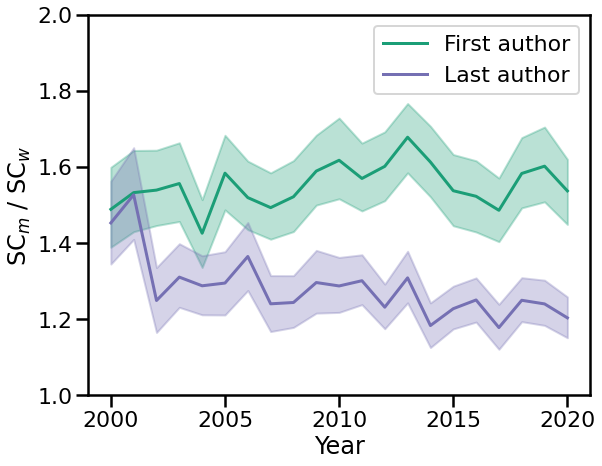

In [44]:

fa_gender_ratio = dat['time_gender_sc_fa_male'] / dat['time_gender_sc_fa_female']
fa_lower = np.percentile(fa_gender_ratio, q=2.5, axis=0)
fa_upper = np.percentile(fa_gender_ratio, q=97.5, axis=0)

la_gender_ratio = dat['time_gender_sc_la_male'] / dat['time_gender_sc_la_female']
la_lower = np.percentile(la_gender_ratio, q=2.5, axis=0)
la_upper = np.percentile(la_gender_ratio, q=97.5, axis=0)

years = np.arange(2000, 2021)

fig, ax = plt.subplots(figsize=(9, 7))

ax.plot(years, np.mean(fa_gender_ratio, axis=0), color=custom_palette[0], label='First author')
ax.fill_between(years, fa_lower, fa_upper, color=custom_palette[0], alpha=.3)


ax.plot(years, np.mean(la_gender_ratio, axis=0), color=custom_palette[1], label='Last author')
ax.fill_between(years, la_lower, la_upper, color=custom_palette[1], alpha=.3)

plt.legend()
plt.xlabel('Year')
plt.ylabel('SC$_m$ / SC$_w$')
ax.set_ylim([1, 2])

if save_figs:
  fig.savefig(base_path + 'fig5_gender/gender_sc_ratio_year.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')

In [45]:
mean_fa_ratios_by_year = np.mean(fa_gender_ratio, axis=0)
print('Lowest gender sc ratio for first authors: {:.4f} and highest {:.4f}'.format(np.min(mean_fa_ratios_by_year), np.max(mean_fa_ratios_by_year)))

Lowest gender sc ratio for first authors: 1.4259 and highest 1.6782


In [46]:
mean_la_ratios_by_year = np.mean(la_gender_ratio, axis=0)
print('Lowest gender sc ratio for last authors: {:.4f} and highest {:.4f}'.format(np.min(mean_la_ratios_by_year), np.max(mean_la_ratios_by_year)))

mean_la_ratios_by_year = np.mean(la_gender_ratio, axis=0)[2:]
print('Excluding first 2 years, lowest gender sc ratio for last authors: {:.4f} and highest {:.4f}'.format(np.min(mean_la_ratios_by_year), np.max(mean_la_ratios_by_year)))

Lowest gender sc ratio for last authors: 1.1780 and highest 1.5269
Excluding first 2 years, lowest gender sc ratio for last authors: 1.1780 and highest 1.3648


## time gender sc

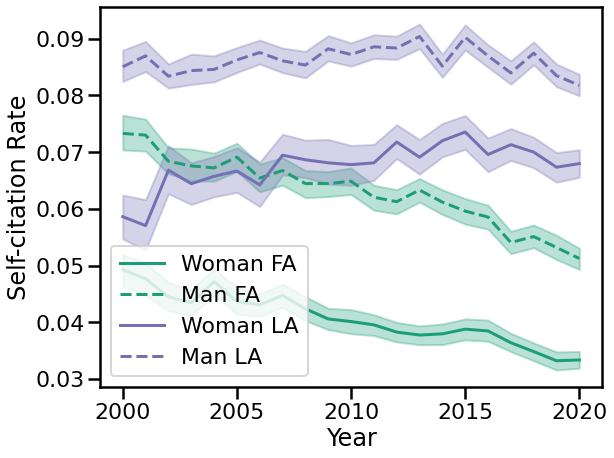

In [47]:
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

years = np.arange(2000, 2021)

fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(years, np.mean(dat['time_gender_sc_fa_female'], axis=0), color=custom_palette[0], label='Woman FA', linestyle=gender_style[0])
ax.fill_between(years, np.percentile(dat['time_gender_sc_fa_female'], q=2.5, axis=0),
                np.percentile(dat['time_gender_sc_fa_female'], q=97.5, axis=0),
                color=custom_palette[0], alpha=.3)

# for first author man
ax.plot(years, np.mean(dat['time_gender_sc_fa_male'], axis=0), color=custom_palette[0], label='Man FA', linestyle=gender_style[1])
ax.fill_between(years, np.percentile(dat['time_gender_sc_fa_male'], q=2.5, axis=0),
                np.percentile(dat['time_gender_sc_fa_male'], q=97.5, axis=0),
                color=custom_palette[0], alpha=.3)

# for last author woman
ax.plot(years, np.mean(dat['time_gender_sc_la_female'], axis=0), color=custom_palette[1], label='Woman LA', linestyle=gender_style[0])
ax.fill_between(years, np.percentile(dat['time_gender_sc_la_female'], q=2.5, axis=0),
                np.percentile(dat['time_gender_sc_la_female'], q=97.5, axis=0),
                color=custom_palette[1], alpha=.3)

# for last author man
ax.plot(years, np.mean(dat['time_gender_sc_la_male'], axis=0), color=custom_palette[1], label='Man LA', linestyle=gender_style[1])
ax.fill_between(years, np.percentile(dat['time_gender_sc_la_male'], q=2.5, axis=0),
                np.percentile(dat['time_gender_sc_la_male'], q=97.5, axis=0),
                color=custom_palette[1], alpha=.3)

plt.legend()
plt.xlabel('Year')
plt.ylabel('Self-citation Rate')
# ax.set_ylim([0, 1])

if save_figs:
  fig.savefig(base_path + 'fig5_gender/gender_sc_year.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')

In [48]:
# assess convergence of self-citation rates with CIs
nboot = np.shape(dat['time_gender_sc_fa_male'])[0]
projection_fa = np.zeros((nboot,))
projection_la = np.zeros((nboot,))
year_range = np.arange(21)

for i in range(nboot):
  regr_fa_female = linregress(year_range, dat['time_gender_sc_fa_female'][i, :])
  regr_fa_male = linregress(year_range, dat['time_gender_sc_fa_male'][i, :])
  projection_fa[i] = (regr_fa_male.intercept - regr_fa_female.intercept) / (regr_fa_female.slope - regr_fa_male.slope)
    
  regr_la_female = linregress(year_range, dat['time_gender_sc_la_female'][i, :])
  regr_la_male = linregress(year_range, dat['time_gender_sc_la_male'][i, :])
  projection_la[i] = (regr_la_male.intercept - regr_la_female.intercept) / (regr_la_female.slope - regr_la_male.slope)

print('For first authors: ' + '{:.2f}'.format(np.mean(projection_fa)) + ' (' + '{:.2f}'.format(np.percentile(projection_fa, q=2.5)) +\
      ', ' + '{:.2f}'.format(np.percentile(projection_fa, q=97.5)) + ')')
print('For last authors: ' + '{:.2f}'.format(np.mean(projection_la)) + ' (' + '{:.2f}'.format(np.percentile(projection_la, q=2.5)) +\
      ', ' + '{:.2f}'.format(np.percentile(projection_la, q=97.5)) + ')')

For first authors: 105.53 (70.17, 171.36)
For last authors: 53.22 (41.49, 72.19)


## gender ac age

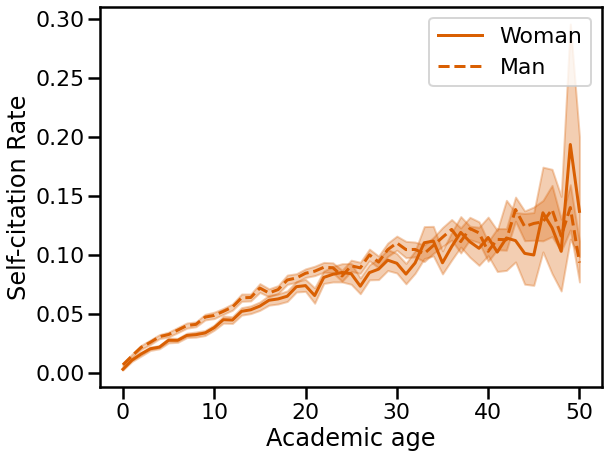

In [49]:
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

ac_ages = np.arange(np.shape(dat['ac_age_gender_sc_male'])[1])

fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(ac_ages, np.mean(dat['ac_age_gender_sc_female'], axis=0), color=custom_palette[2], label='Woman', linestyle=gender_style[0])
ax.fill_between(ac_ages, np.percentile(dat['ac_age_gender_sc_female'], q=2.5, axis=0),
                np.percentile(dat['ac_age_gender_sc_female'], q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)

# for first author man
ax.plot(ac_ages, np.mean(dat['ac_age_gender_sc_male'], axis=0), color=custom_palette[2], label='Man', linestyle=gender_style[1])
ax.fill_between(ac_ages, np.percentile(dat['ac_age_gender_sc_male'], q=2.5, axis=0),
                np.percentile(dat['ac_age_gender_sc_male'], q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)

plt.legend()
plt.xlabel('Academic age')
plt.ylabel('Self-citation Rate')
# ax.set_ylim([0, 1])

if save_figs:
  fig.savefig(base_path + 'fig5_gender/gender_sc_ac_age.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')



## gender ac age ratio

In [50]:
save_figs = False

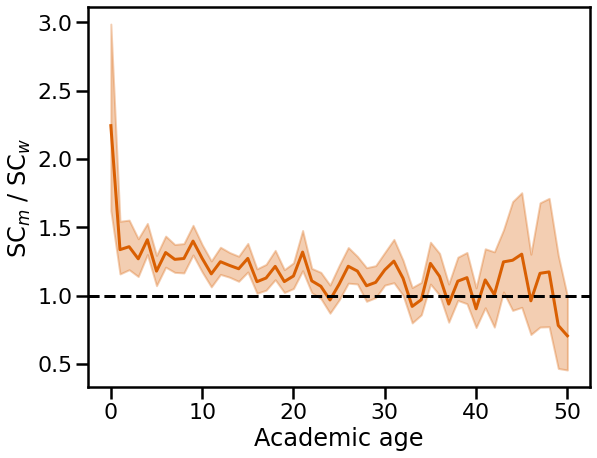

In [51]:
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

ac_ages = np.arange(np.shape(dat['ac_age_gender_sc_male'])[1])
sc_ratio_ac_age = dat['ac_age_gender_sc_male'] / dat['ac_age_gender_sc_female']

fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(ac_ages, np.mean(sc_ratio_ac_age, axis=0), color=custom_palette[2])
ax.fill_between(ac_ages, np.percentile(sc_ratio_ac_age, q=2.5, axis=0),
                np.percentile(sc_ratio_ac_age, q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)


plt.xlabel('Academic age')
plt.ylabel('SC$_m$ / SC$_w$')
ax.axhline(y=1, color='black', linestyle='--')
# ax.set_ylim([0, 1])

if save_figs:
  fig.savefig(base_path + 'fig5_gender/gender_sc_ratio_ac_age.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')



In [52]:
# print out mean ratios by academic age (after running above)
np.mean(sc_ratio_ac_age, axis=0)

array([2.24364781, 1.33577301, 1.35734359, 1.26864766, 1.40860699,
       1.17858189, 1.31458338, 1.26468859, 1.27079585, 1.39850585,
       1.27199714, 1.15835085, 1.24743033, 1.22010408, 1.19584685,
       1.27164945, 1.10114952, 1.12798981, 1.21325857, 1.10195409,
       1.14290276, 1.31790595, 1.10730635, 1.06756469, 0.96733988,
       1.08262196, 1.21410033, 1.17900836, 1.07149449, 1.09604227,
       1.18756591, 1.25182487, 1.12595621, 0.92029496, 0.96926716,
       1.23516273, 1.14027623, 0.9374086 , 1.10509873, 1.13067817,
       0.90266732, 1.11423204, 1.00616491, 1.24617585, 1.25816093,
       1.30271082, 0.96112481, 1.16245981, 1.17284118, 0.78067474,
       0.70498678])

In [53]:
# this code makes df of gender sc rates by academic age
df_tmp = df_all[ (df_all.gender_binary!='Error') & (df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all.ac_age.isin(dat['ac_age_to_keep']))]
df_ac_age_gender_summary = df_tmp.groupby(['ac_age', 'gender_binary'], as_index=False).agg({'numpapers':'sum', 'numref':'sum', 'sc_count':'sum'})
df_ac_age_gender_summary['sc_rate'] = df_ac_age_gender_summary['sc_count'] / df_ac_age_gender_summary['numref']
df_ac_age_gender_summary.head(25)

,ac_age,gender_binary,numpapers,numref,sc_count,sc_rate
0,0.0,Female,1642.0,100363,310,0.003089
1,0.0,Male,1399.0,83628,569,0.006804
2,1.0,Female,957.0,60198,651,0.010814
3,1.0,Male,889.0,54748,788,0.014393
4,2.0,Female,1128.0,69211,1108,0.016009
5,2.0,Male,1112.0,67148,1454,0.021654
6,3.0,Female,1227.0,77068,1575,0.020436
7,3.0,Male,1274.0,77502,2001,0.025819
8,4.0,Female,1250.0,80656,1758,0.021796
9,4.0,Male,1329.0,79046,2423,0.030653


In [54]:
# this code looks at gender sc differences in first 10 years
df_tmp = df_all[ (df_all.gender_binary!='Error') & (df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all.ac_age.isin([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))]
df_ac_age_gender_summary = df_tmp.groupby(['gender_binary'], as_index=False).agg({'numpapers':'sum', 'numref':'sum', 'sc_count':'sum'})
df_ac_age_gender_summary['sc_rate'] = df_ac_age_gender_summary['sc_count'] / df_ac_age_gender_summary['numref']
print('In first 10 years, men sc rate: {:.4f}, women sc rate: {:.4f}, ratio: {:.4f}'.format(float(df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Male']['sc_rate']),
                                                                                            float(df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Female']['sc_rate']),
                                                                                            float(df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Male']['sc_rate'])/float(df_ac_age_gender_summary[df_ac_age_gender_summary.gender_binary=='Female']['sc_rate'])))
df_ac_age_gender_summary

In first 10 years, men sc rate: 0.0323, women sc rate: 0.0228, ratio: 1.4143


,gender_binary,numpapers,numref,sc_count,sc_rate
0,Female,12558.0,781096,17836,0.022835
1,Male,14574.0,884331,28560,0.032296


## bar plot sc by numpapers groups

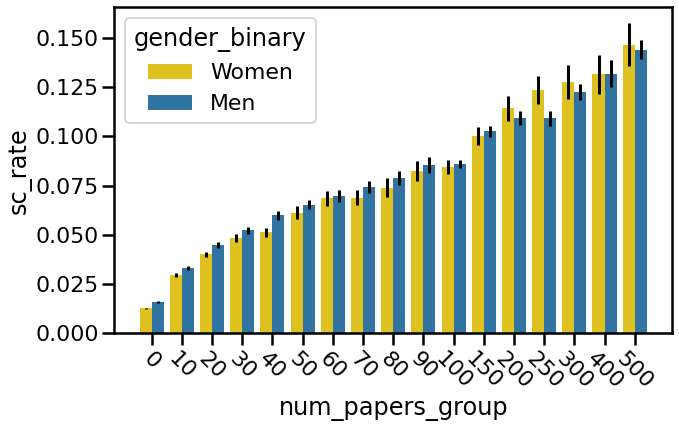

In [55]:
#  'num_papers_groups', 'num_papers_sc_groups_female', 'num_papers_sc_groups_male',
num_papers_groups = dat['num_papers_groups']
ngroups = len(num_papers_groups)
num_papers_sc_groups_male = dat['num_papers_sc_groups_male']
num_papers_sc_groups_female = dat['num_papers_sc_groups_female']

num_papers_sc_groups_male_lower = np.percentile(num_papers_sc_groups_male, q=2.5, axis=0)
num_papers_sc_groups_male_upper = np.percentile(num_papers_sc_groups_male, q=97.5, axis=0)

num_papers_sc_groups_female_lower = np.percentile(num_papers_sc_groups_female, q=2.5, axis=0)
num_papers_sc_groups_female_upper = np.percentile(num_papers_sc_groups_female, q=97.5, axis=0)


gender_binary = ['Women']*len(num_papers_groups)
gender_binary.extend(['Men']*len(num_papers_groups))

df_plot = pd.DataFrame({'gender_binary':gender_binary, 'num_papers_group':np.tile(num_papers_groups, 2), 'sc_rate':np.hstack( (np.mean(num_papers_sc_groups_female, axis=0), np.mean(num_papers_sc_groups_male, axis=0)) )})

sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=df_plot, x='num_papers_group', y='sc_rate', ci=None, hue='gender_binary', ax=ax, palette=['#ffd700', (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)])


for i, p in enumerate(ax.patches):
    x = p.get_x()  # get the bottom left x corner of the bar
    w = p.get_width()  # get width of bar
    h = p.get_height()  # get height of bar
    
    if i<ngroups:
      min_y = num_papers_sc_groups_female_lower[ i ]
      max_y = num_papers_sc_groups_female_upper[ i ]
    else:
      min_y = num_papers_sc_groups_male_lower[ i - ngroups]
      max_y = num_papers_sc_groups_male_upper[ i - ngroups]

    plt.vlines(x+w/2, min_y, max_y, color='k')  # draw a vertical line
  
plt.xticks(rotation=-45)
fig.savefig(base_path + 'fig5_gender/sc_by_numpapers.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')

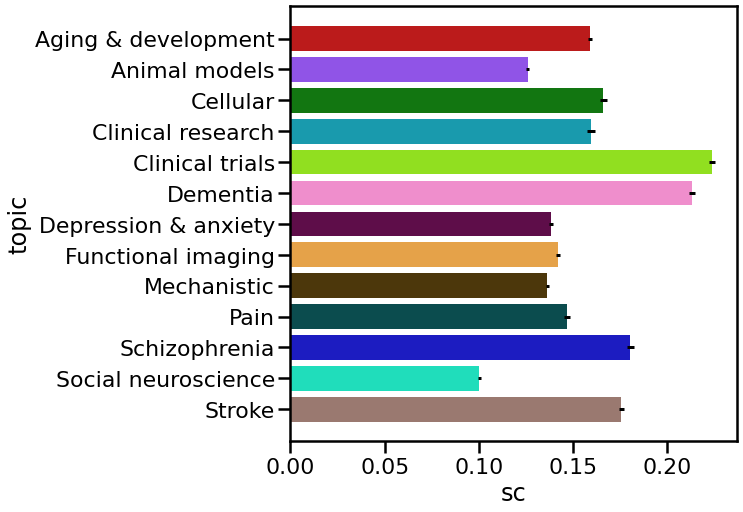

In [56]:
author_type = 'Any'
num_topics = 13
from seaborn.utils import ci
import colorcet as cc

# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.25)
def qupper(x):
    return x.quantile(0.75)

topic_fa_sc=dat['topic_fa_sc']
topic_la_sc=dat['topic_la_sc']
topic_any_sc=dat['topic_any_sc']

topic_names = np.array(['Clinical research', 'Aging & development', 'Dementia', 'Functional imaging',
               'Pain', 'Animal models', 'Stroke', 'Clinical trials', 'Schizophrenia', 'Cellular', 
               'Mechanistic', 'Depression & anxiety', 'Social neuroscience'])
alphabetical_order = np.argsort(topic_names)
ntopics = len(topic_names)

topic_sc_array = np.array([])
auth_array = np.array([])
topic_id_array = np.array([])
num_boot_iters = np.shape(topic_fa_sc)[0]
for i in range(ntopics):
  topic_sc_array = np.concatenate([topic_sc_array, topic_fa_sc[:, i], topic_la_sc[:, i], topic_any_sc[:, i]])
  auth_array = np.concatenate([auth_array, num_boot_iters*['FA'], num_boot_iters*['LA'], num_boot_iters*['Any']])
  # topic_id_array = np.concatenate([topic_id_array, 3*num_boot_iters*[i]])
  topic_id_array = np.concatenate([topic_id_array, 3*num_boot_iters*[topic_names[i]]])

df_topics = pd.DataFrame({'topic':topic_id_array, 'auth':auth_array, 'sc':topic_sc_array})
df_topics = df_topics.sort_values('topic')

fig, ax = plt.subplots(figsize=(8, 8))
many_palette = sns.color_palette(cc.glasbey, n_colors=num_topics)
sns.barplot(data=df_topics[df_topics['auth']==author_type], y='topic', x='sc', ci=None, orient='h', ax=ax, palette=many_palette)

# get quantiles for CI, then add error bars
df_quantiles = df_topics[df_topics.auth==author_type].groupby(['topic']).agg({'sc': [qlower, qupper]})
df_mean = df_topics[df_topics.auth==author_type].groupby(['topic']).agg({'sc': 'mean'})
ci_vals = np.zeros((2, 13))
ci_vals[0, :] = np.abs(df_quantiles['sc']['qlower'] - df_mean['sc'])
ci_vals[1, :] = df_quantiles['sc']['qupper'] - df_mean['sc']
ax.errorbar(x=df_mean.sc, y=np.arange(0, 13), xerr=ci_vals, ls='', lw=3, color='black')


if save_figs:
  fig.savefig(base_path + 'fig4_topics/topics_' + str(num_topics) + '_' + author_type + '.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')

Look at number of papers by ac age

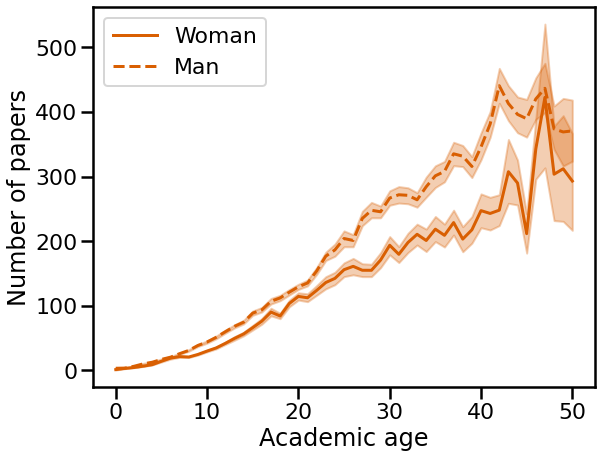

In [58]:
# Plot number of papers by academic age
save_figs = True
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

ac_ages = np.arange(np.shape(dat['num_papers_by_ac_age_male'])[1])

ac_age_gender_numpapers_female = dat['num_papers_by_ac_age_female'][:, :, 1]  # 0 is ac age

ac_age_gender_numpapers_male = dat['num_papers_by_ac_age_male'][:, :, 1]  # 0 is ac age


fig, ax = plt.subplots(figsize=(9, 7))

# for first author woman
ax.plot(ac_ages, np.mean(ac_age_gender_numpapers_female, axis=0), color=custom_palette[2], label='Woman', linestyle=gender_style[0])
ax.fill_between(ac_ages, np.percentile(ac_age_gender_numpapers_female, q=2.5, axis=0),
                np.percentile(ac_age_gender_numpapers_female, q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)

# for first author man
ax.plot(ac_ages, np.mean(ac_age_gender_numpapers_male, axis=0), color=custom_palette[2], label='Man', linestyle=gender_style[1])
ax.fill_between(ac_ages, np.percentile(ac_age_gender_numpapers_male, q=2.5, axis=0),
                np.percentile(ac_age_gender_numpapers_male, q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)

plt.legend()
plt.xlabel('Academic age')
plt.ylabel('Number of papers')
# ax.set_ylim([0, 1])

if save_figs:
  fig.savefig(base_path + 'fig5_gender/gender_numpapers_ac_age.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')



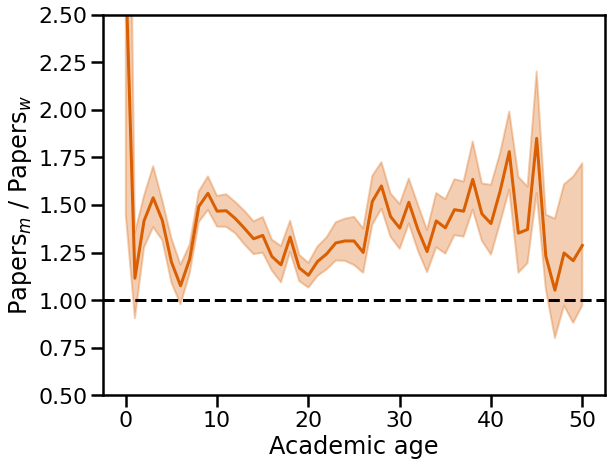

In [59]:
# Plot number of papers by academic age
save_figs = True
gender_palette = ['#0b03fc', '#fceb03']
gender_style = ['-', '--']

ac_ages = np.arange(np.shape(dat['num_papers_by_ac_age_male'])[1])

ac_age_gender_numpapers_female = dat['num_papers_by_ac_age_female'][:, :, 1]  # 0 is ac age

ac_age_gender_numpapers_male = dat['num_papers_by_ac_age_male'][:, :, 1]  # 0 is ac age
paper_ratio_ac_age = ac_age_gender_numpapers_male / ac_age_gender_numpapers_female


fig, ax = plt.subplots(figsize=(9, 7))

# for ratio of papers by academic age
ax.plot(ac_ages, np.mean(paper_ratio_ac_age, axis=0), color=custom_palette[2])
ax.fill_between(ac_ages, np.percentile(paper_ratio_ac_age, q=2.5, axis=0),
                np.percentile(paper_ratio_ac_age, q=97.5, axis=0),
                color=custom_palette[2], alpha=.3)


ax.axhline(y=1, color='black', linestyle='--')
plt.xlabel('Academic age')
plt.ylabel('Papers$_m$ / Papers$_w$')
ax.set_ylim([0.5, 2.5])

if save_figs:
  fig.savefig(base_path + 'fig5_gender/gender_ratio_numpapers_ac_age.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')



# Null models / permutation testing

In [62]:
def calc_p_from_null(null_dist, thresh):
  # two-sided
  return np.mean(np.abs(null_dist)>np.abs(thresh))

## For comparing neurosci to neurology

In [63]:
df_all.field.unique()

array(['Neuroscience', 'Neurology', 'Psychiatry'], dtype=object)

In [ ]:
npermutations = 10000
null_diff_fa = np.zeros((npermutations, ))
null_diff_la = np.zeros((npermutations, ))
null_diff_any = np.zeros((npermutations, ))

for seed in tqdm(range(npermutations)):
  np.random.seed(seed)

  # Null distribution for neuroscience vs neurology
  df_null = df_all[(df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['field'].isin(['Neuroscience', 'Neurology']))]
  df_null['field'] = np.random.permutation(df_null.field)
  df_null['fa'].sum() / df_null['numref'].sum()
  df_null_summary = df_null.groupby(['SC Type', 'field'], as_index=False).agg({'fa':'sum', 'la':'sum', 'any':'sum', 'numref':'sum'})

  author_type = 'fa'
  df1 = df_null_summary[(df_null_summary['SC Type']==author_type.upper()) & (df_null_summary['field']=='Neuroscience')]
  df2 = df_null_summary[(df_null_summary['SC Type']==author_type.upper()) & (df_null_summary['field']=='Neurology')]
  null_diff_fa[seed] = df1[author_type].sum() / df1['numref'].sum() - df2[author_type].sum() / df2['numref'].sum()
  
  author_type = 'la'
  df1 = df_null_summary[(df_null_summary['SC Type']==author_type.upper()) & (df_null_summary['field']=='Neuroscience')]
  df2 = df_null_summary[(df_null_summary['SC Type']==author_type.upper()) & (df_null_summary['field']=='Neurology')]
  null_diff_la[seed] = df1[author_type].sum() / df1['numref'].sum() - df2[author_type].sum() / df2['numref'].sum()
  
  author_type = 'any'
  df1 = df_null_summary[(df_null_summary['SC Type']=='Any') & (df_null_summary['field']=='Neuroscience')]
  df2 = df_null_summary[(df_null_summary['SC Type']=='Any') & (df_null_summary['field']=='Neurology')]
  null_diff_any[seed] = df1[author_type].sum() / df1['numref'].sum() - df2[author_type].sum() / df2['numref'].sum()

np.savez('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/neuroscience_neurology.npz', 
         null_diff_fa=null_diff_fa, null_diff_la=null_diff_la, null_diff_any=null_diff_any, allow_pickle=True)

# now compare to means of neurology / neurosci diffs
print(calc_p_from_null(null_diff_fa, -.0134))
print(calc_p_from_null(null_diff_la, (.0689-.0855)))
print(calc_p_from_null(null_diff_any, (.1200-.1666)))

In [65]:
dat = np.load('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/neuroscience_neurology.npz')
null_fa = dat['null_diff_fa']
null_la = dat['null_diff_la']
null_any = dat['null_diff_any']

In [66]:
df_summary = df_all[df_all.Year.isin([2016, 2017, 2018, 2019, 2020])].groupby(['field', 'SC Type'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_summary['sc_rate'] = df_summary['sc_count'] / df_summary['numref']

true_fa = df_summary[ (df_summary.field=='Neuroscience') & (df_summary['SC Type']=='FA') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Neurology') & (df_summary['SC Type']=='FA') ]['sc_rate'].values[0]
true_la = df_summary[ (df_summary.field=='Neuroscience') & (df_summary['SC Type']=='LA') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Neurology') & (df_summary['SC Type']=='LA') ]['sc_rate'].values[0]
true_any = df_summary[ (df_summary.field=='Neuroscience') & (df_summary['SC Type']=='Any') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Neurology') & (df_summary['SC Type']=='Any') ]['sc_rate'].values[0]

print('True first author: {:.4f}, p={:.4f}; last author: {:.4f}, p={:.4f}; any author {:.4f}, p={:.4f}'.format(true_fa, calc_p_from_null(null_fa, true_fa), true_la,
                                                                                                               calc_p_from_null(null_la, true_la), true_any, calc_p_from_null(null_any, true_any)))

df_summary

True first author: -0.0138, p=0.0000; last author: -0.0247, p=0.0000; any author -0.0673, p=0.0000


,field,SC Type,sc_count,numref,sc_rate
0,Neurology,Any,152150,875368,0.173813
1,Neurology,FA,42950,875368,0.049065
2,Neurology,LA,79352,875368,0.090650
3,Neuroscience,Any,103322,969896,0.106529
4,Neuroscience,FA,34227,969896,0.035289
5,Neuroscience,LA,63948,969896,0.065933
6,Psychiatry,Any,118908,749984,0.158547
7,Psychiatry,FA,39573,749984,0.052765
8,Psychiatry,LA,63138,749984,0.084186


## comparing neurosci to psychiatry

In [ ]:
npermutations = 10000
null_diff_fa = np.zeros((npermutations, ))
null_diff_la = np.zeros((npermutations, ))
null_diff_any = np.zeros((npermutations, ))

for seed in tqdm(range(npermutations)):
  np.random.seed(seed)

  # Null distribution for neuroscience vs psychiatry
  df_null = df_all[(df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['field'].isin(['Neuroscience', 'Psychiatry']))]
  df_null['field'] = np.random.permutation(df_null.field)
  df_null['fa'].sum() / df_null['numref'].sum()
  df_null_summary = df_null.groupby(['SC Type', 'field'], as_index=False).agg({'fa':'sum', 'la':'sum', 'any':'sum', 'numref':'sum'})

  author_type = 'fa'
  df1 = df_null_summary[(df_null_summary['SC Type']==author_type.upper()) & (df_null_summary['field']=='Neuroscience')]
  df2 = df_null_summary[(df_null_summary['SC Type']==author_type.upper()) & (df_null_summary['field']=='Psychiatry')]
  null_diff_fa[seed] = df1[author_type].sum() / df1['numref'].sum() - df2[author_type].sum() / df2['numref'].sum()
  
  author_type = 'la'
  df1 = df_null_summary[(df_null_summary['SC Type']==author_type.upper()) & (df_null_summary['field']=='Neuroscience')]
  df2 = df_null_summary[(df_null_summary['SC Type']==author_type.upper()) & (df_null_summary['field']=='Psychiatry')]
  null_diff_la[seed] = df1[author_type].sum() / df1['numref'].sum() - df2[author_type].sum() / df2['numref'].sum()
  
  author_type = 'any'
  df1 = df_null_summary[(df_null_summary['SC Type']=='Any') & (df_null_summary['field']=='Neuroscience')]
  df2 = df_null_summary[(df_null_summary['SC Type']=='Any') & (df_null_summary['field']=='Psychiatry')]
  null_diff_any[seed] = df1[author_type].sum() / df1['numref'].sum() - df2[author_type].sum() / df2['numref'].sum()


np.savez('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/neuroscience_psychiatry.npz', 
         null_diff_fa=null_diff_fa, null_diff_la=null_diff_la, null_diff_any=null_diff_any, allow_pickle=True)

# now compare to means of psychiatry / neurosci diffs
print(calc_p_from_null(null_diff_fa, (.034-.0482)))
print(calc_p_from_null(null_diff_la, (.0689-.0815)))
print(calc_p_from_null(null_diff_any, (.1200-.1510)))

In [68]:
dat = np.load('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/neuroscience_psychiatry.npz')
null_fa = dat['null_diff_fa']
null_la = dat['null_diff_la']
null_any = dat['null_diff_any']

In [69]:
df_summary = df_all[df_all.Year.isin([2016, 2017, 2018, 2019, 2020])].groupby(['field', 'SC Type'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_summary['sc_rate'] = df_summary['sc_count'] / df_summary['numref']

true_fa = df_summary[ (df_summary.field=='Neuroscience') & (df_summary['SC Type']=='FA') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Psychiatry') & (df_summary['SC Type']=='FA') ]['sc_rate'].values[0]
true_la = df_summary[ (df_summary.field=='Neuroscience') & (df_summary['SC Type']=='LA') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Psychiatry') & (df_summary['SC Type']=='LA') ]['sc_rate'].values[0]
true_any = df_summary[ (df_summary.field=='Neuroscience') & (df_summary['SC Type']=='Any') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Psychiatry') & (df_summary['SC Type']=='Any') ]['sc_rate'].values[0]

print('True first author: {:.4f}, p={:.4f}; last author: {:.4f}, p={:.4f}; any author {:.4f}, p={:.4f}'.format(true_fa, calc_p_from_null(null_fa, true_fa), true_la,
                                                                                                               calc_p_from_null(null_la, true_la), true_any, calc_p_from_null(null_any, true_any)))

df_summary

True first author: -0.0175, p=0.0000; last author: -0.0183, p=0.0000; any author -0.0520, p=0.0000


,field,SC Type,sc_count,numref,sc_rate
0,Neurology,Any,152150,875368,0.173813
1,Neurology,FA,42950,875368,0.049065
2,Neurology,LA,79352,875368,0.090650
3,Neuroscience,Any,103322,969896,0.106529
4,Neuroscience,FA,34227,969896,0.035289
5,Neuroscience,LA,63948,969896,0.065933
6,Psychiatry,Any,118908,749984,0.158547
7,Psychiatry,FA,39573,749984,0.052765
8,Psychiatry,LA,63138,749984,0.084186


## comparing neurology to psychiatry

In [ ]:
npermutations = 10000
null_diff_fa = np.zeros((npermutations, ))
null_diff_la = np.zeros((npermutations, ))
null_diff_any = np.zeros((npermutations, ))

for seed in tqdm(range(npermutations)):
  np.random.seed(seed)

  # Null distribution for psychiatry vs neurology
  df_null = df_all[(df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['field'].isin(['Neurology', 'Psychiatry']))]
  df_null['field'] = np.random.permutation(df_null.field)
  df_null['fa'].sum() / df_null['numref'].sum()
  df_null_summary = df_null.groupby(['SC Type', 'field'], as_index=False).agg({'fa':'sum', 'la':'sum', 'any':'sum', 'numref':'sum'})

  author_type = 'fa'
  df1 = df_null_summary[(df_null_summary['SC Type']==author_type.upper()) & (df_null_summary['field']=='Neurology')]
  df2 = df_null_summary[(df_null_summary['SC Type']==author_type.upper()) & (df_null_summary['field']=='Psychiatry')]
  null_diff_fa[seed] = df1[author_type].sum() / df1['numref'].sum() - df2[author_type].sum() / df2['numref'].sum()
  
  author_type = 'la'
  df1 = df_null_summary[(df_null_summary['SC Type']==author_type.upper()) & (df_null_summary['field']=='Neurology')]
  df2 = df_null_summary[(df_null_summary['SC Type']==author_type.upper()) & (df_null_summary['field']=='Psychiatry')]
  null_diff_la[seed] = df1[author_type].sum() / df1['numref'].sum() - df2[author_type].sum() / df2['numref'].sum()
  
  author_type = 'any'
  df1 = df_null_summary[(df_null_summary['SC Type']=='Any') & (df_null_summary['field']=='Neurology')]
  df2 = df_null_summary[(df_null_summary['SC Type']=='Any') & (df_null_summary['field']=='Psychiatry')]
  null_diff_any[seed] = df1[author_type].sum() / df1['numref'].sum() - df2[author_type].sum() / df2['numref'].sum()



np.savez('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/neurology_psychiatry.npz', 
         null_diff_fa=null_diff_fa, null_diff_la=null_diff_la, null_diff_any=null_diff_any, allow_pickle=True)


# now compare to means of psychiatry / neurosci diffs
print(calc_p_from_null(null_diff_fa,(.0474-.0482)))
print(calc_p_from_null(null_diff_la,(.0855-.0815)))
print(calc_p_from_null(null_diff_any,(.1666-.1510)))

In [70]:
dat = np.load('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/neurology_psychiatry.npz')
null_fa = dat['null_diff_fa']
null_la = dat['null_diff_la']
null_any = dat['null_diff_any']

In [71]:
df_summary = df_all[df_all.Year.isin([2016, 2017, 2018, 2019, 2020])].groupby(['field', 'SC Type'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_summary['sc_rate'] = df_summary['sc_count'] / df_summary['numref']

true_fa = df_summary[ (df_summary.field=='Neurology') & (df_summary['SC Type']=='FA') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Psychiatry') & (df_summary['SC Type']=='FA') ]['sc_rate'].values[0]
true_la = df_summary[ (df_summary.field=='Neurology') & (df_summary['SC Type']=='LA') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Psychiatry') & (df_summary['SC Type']=='LA') ]['sc_rate'].values[0]
true_any = df_summary[ (df_summary.field=='Neurology') & (df_summary['SC Type']=='Any') ]['sc_rate'].values[0] - df_summary[ (df_summary.field=='Psychiatry') & (df_summary['SC Type']=='Any') ]['sc_rate'].values[0]

print('True first author: {:.4f}, p={:.4f}; last author: {:.4f}, p={:.4f}; any author {:.4f}, p={:.4f}'.format(true_fa, calc_p_from_null(null_fa, true_fa), true_la,
                                                                                                               calc_p_from_null(null_la, true_la), true_any, calc_p_from_null(null_any, true_any)))

df_summary

True first author: -0.0037, p=0.0001; last author: 0.0065, p=0.0000; any author 0.0153, p=0.0000


,field,SC Type,sc_count,numref,sc_rate
0,Neurology,Any,152150,875368,0.173813
1,Neurology,FA,42950,875368,0.049065
2,Neurology,LA,79352,875368,0.090650
3,Neuroscience,Any,103322,969896,0.106529
4,Neuroscience,FA,34227,969896,0.035289
5,Neuroscience,LA,63948,969896,0.065933
6,Psychiatry,Any,118908,749984,0.158547
7,Psychiatry,FA,39573,749984,0.052765
8,Psychiatry,LA,63138,749984,0.084186


## compare fa/la

In [ ]:
npermutations = 10000

# df_all['sc_count'] = [df_all.iloc[i][auth_type.lower()] for auth_type in list(df_all['SC Type'])]  # Make count column
df_all['title_auth'] = df_all['Title'] + df_all['Authors']  # add title + author name combination to make it easier to identify unique papers

null_diff_overall = np.zeros((npermutations, ))
null_diff_neuroscience = np.zeros((npermutations, ))
null_diff_neurology = np.zeros((npermutations, ))
null_diff_psychiatry = np.zeros((npermutations, ))


for seed in tqdm(range(npermutations)):
  np.random.seed(seed)

  # Null distribution for first vs last authors
  df_null = df_all[(df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['SC Type'].isin(['FA', 'LA']))]
  unique_title_auth = df_null.title_auth.unique()  # unique combinations of title + author
  change_titles = np.random.permutation(unique_title_auth)[:int(len(unique_title_auth)/2)]  # mark half of titles to change
  change_loc = np.where(df_null['title_auth'].isin(change_titles))[0]  # find index locations of where to change
  # now swap first and last author self-citation types
  df_null.iloc[change_loc, df_null.columns.get_loc('SC Type')] = df_null.iloc[change_loc, df_null.columns.get_loc('SC Type')].replace('FA', 'LA_new').replace('LA', 'FA_new').replace('FA_new', 'FA').replace('LA_new', 'LA')
  df_null_summary = df_null.groupby(['SC Type', 'field'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})

  # overall
  field = 'Neurology'
  df1 = df_null_summary[(df_null_summary['SC Type']=='FA')]
  df2 = df_null_summary[(df_null_summary['SC Type']=='LA')]
  null_diff_overall[seed] = df1['sc_count'].sum() / df1['numref'].sum() - df2['sc_count'].sum() / df2['numref'].sum()

  field = 'Neurology'
  df1 = df_null_summary[(df_null_summary['SC Type']=='FA') & (df_null_summary['field']==field)]
  df2 = df_null_summary[(df_null_summary['SC Type']=='LA') & (df_null_summary['field']==field)]
  null_diff_neurology[seed] = df1['sc_count'].sum() / df1['numref'].sum() - df2['sc_count'].sum() / df2['numref'].sum()
  
  field = 'Neuro'
  df1 = df_null_summary[(df_null_summary['SC Type']=='FA') & (df_null_summary['field']==field)]
  df2 = df_null_summary[(df_null_summary['SC Type']=='LA') & (df_null_summary['field']==field)]
  null_diff_neuroscience[seed] = df1['sc_count'].sum() / df1['numref'].sum() - df2['sc_count'].sum() / df2['numref'].sum()
  
  field = 'Psychiatry'
  df1 = df_null_summary[(df_null_summary['SC Type']=='FA') & (df_null_summary['field']==field)]
  df2 = df_null_summary[(df_null_summary['SC Type']=='LA') & (df_null_summary['field']==field)]
  null_diff_psychiatry[seed] = df1['sc_count'].sum() / df1['numref'].sum() - df2['sc_count'].sum() / df2['numref'].sum()


# now compare to means of psychiatry / neurosci diffs

np.savez('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/fa_la.npz', 
         null_diff_overall=null_diff_overall, null_diff_neurology=null_diff_neurology, null_diff_neuroscience=null_diff_neuroscience,
         null_diff_psychiatry=null_diff_psychiatry, allow_pickle=True)


In [72]:
df_true_summary_overall = df_all[(df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['SC Type'].isin(['FA', 'LA']))].groupby(['SC Type'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_true_summary_overall['sc_rate'] = df_true_summary_overall['sc_count'] / df_true_summary_overall['numref']

df_true_summary = df_all[(df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['SC Type'].isin(['FA', 'LA']))].groupby(['SC Type', 'field'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_true_summary['sc_rate'] = df_true_summary['sc_count'] / df_true_summary['numref']
df_true_summary

,SC Type,field,sc_count,numref,sc_rate
0,FA,Neurology,42950,875368,0.049065
1,FA,Neuroscience,34227,969896,0.035289
2,FA,Psychiatry,39573,749984,0.052765
3,LA,Neurology,79352,875368,0.090650
4,LA,Neuroscience,63948,969896,0.065933
5,LA,Psychiatry,63138,749984,0.084186


In [73]:
df_true_summary

,SC Type,field,sc_count,numref,sc_rate
0,FA,Neurology,42950,875368,0.049065
1,FA,Neuroscience,34227,969896,0.035289
2,FA,Psychiatry,39573,749984,0.052765
3,LA,Neurology,79352,875368,0.090650
4,LA,Neuroscience,63948,969896,0.065933
5,LA,Psychiatry,63138,749984,0.084186


In [74]:
float(df_true_summary_overall[df_true_summary_overall['SC Type']=='FA']['sc_rate'])

0.04498606684216692

In [75]:
dat = np.load('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/fa_la.npz')

p_fa_la_overall = calc_p_from_null(dat['null_diff_overall'], 
                                   float(df_true_summary_overall[df_true_summary_overall['SC Type']=='FA']['sc_rate']) - float(df_true_summary_overall[df_true_summary_overall['SC Type']=='LA']['sc_rate']) )

p_fa_la_neurology = calc_p_from_null(dat['null_diff_neurology'], 
                                   float(df_true_summary[(df_true_summary['SC Type']=='FA') & (df_true_summary.field=='Neurology')]['sc_rate']) - float(df_true_summary[(df_true_summary['SC Type']=='LA') & (df_true_summary.field=='Neurology')]['sc_rate']) )

p_fa_la_neuroscience = calc_p_from_null(dat['null_diff_neuroscience'], 
                                   float(df_true_summary[(df_true_summary['SC Type']=='FA') & (df_true_summary.field=='Neuroscience')]['sc_rate']) - float(df_true_summary[(df_true_summary['SC Type']=='LA') & (df_true_summary.field=='Neuroscience')]['sc_rate']) )

p_fa_la_psychiatry = calc_p_from_null(dat['null_diff_psychiatry'], 
                                   float(df_true_summary[(df_true_summary['SC Type']=='FA') & (df_true_summary.field=='Psychiatry')]['sc_rate']) - float(df_true_summary[(df_true_summary['SC Type']=='LA') & (df_true_summary.field=='Psychiatry')]['sc_rate']) )

print('First vs last author p values for overall {:.4f}, neurology {:.4f}, neuroscience {:.4f}, psychiatry {:.4f}'.format(p_fa_la_overall, p_fa_la_neurology, p_fa_la_neuroscience, p_fa_la_psychiatry))

First vs last author p values for overall 0.0000, neurology 0.0000, neuroscience 0.0000, psychiatry 0.0000


## Compare men/women FA in 2020

In [76]:
df_gender_sc_summary = df_all[ (df_all['SC Type']=='FA') & (df_all.Year.isin([2020])) & (df_all.gender_binary.isin(['Female', 'Male'])) ].groupby(['gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum', 'numpapers':'sum'})
df_gender_sc_summary['sc_rate'] = df_gender_sc_summary['sc_count'] / df_gender_sc_summary['numref']
df_gender_sc_summary

,gender_binary,sc_count,numref,numpapers,sc_rate
0,Female,7103,212923,3237.0,0.033359
1,Male,12957,252961,3984.0,0.051221


In [ ]:
npermutations = 10000 # 10000
null_diff_men_minus_women = np.zeros((npermutations, ))

auth_type = 'LA'

# find true difference
df_gender_sc_summary = df_all[ (df_all['SC Type']==auth_type) & (df_all.Year.isin([2020])) & (df_all.gender_binary.isin(['Female', 'Male'])) ].groupby(['gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum', 'numpapers':'sum'})
df_gender_sc_summary['sc_rate'] = df_gender_sc_summary['sc_count'] / df_gender_sc_summary['numref']
true_m = df_gender_sc_summary[df_gender_sc_summary.gender_binary=='Male']['sc_rate'].values[0]
true_w = df_gender_sc_summary[df_gender_sc_summary.gender_binary=='Female']['sc_rate'].values[0]
true_diff = true_m - true_w

for seed in tqdm(range(npermutations)):
  np.random.seed(seed)

  # Null distribution for neuroscience vs neurology
  df_null = df_all[ (df_all['SC Type']==auth_type) & (df_all.Year.isin([2020])) & (df_all.gender_binary.isin(['Female', 'Male'])) ]
  df_null['gender_binary'] = np.random.permutation(df_null.gender_binary)
  df_null_summary = df_null.groupby(['gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum', 'numpapers':'sum'})
  df_null_summary['sc_rate'] = df_null_summary['sc_count'] / df_null_summary['numref']

  null_diff_men_minus_women[seed] = df_null_summary[df_null_summary.gender_binary=='Male']['sc_rate'].values[0] - df_null_summary[df_null_summary.gender_binary=='Female']['sc_rate'].values[0]

np.savez('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/men_women_' + auth_type + '_2020.npz', 
         null_diff_men_minus_women=null_diff_men_minus_women, true_diff=true_diff, true_m=true_m, true_w=true_w, allow_pickle=True)



  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10000/10000 [10:52<00:00, 15.32it/s]


In [77]:
auth_type = 'FA'
dat = np.load('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/men_women_' + auth_type + '_2020.npz')
null_diff_men_minus_women = dat['null_diff_men_minus_women']
print('True difference: {:.4f}, p value: {:.4f}'.format(dat['true_diff'], calc_p_from_null(null_diff_men_minus_women, dat['true_diff'])))

True difference: 0.0179, p value: 0.0000


In [78]:
auth_type = 'LA'
dat = np.load('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/men_women_' + auth_type + '_2020.npz')
null_diff_men_minus_women = dat['null_diff_men_minus_women']
print('True difference: {:.4f}, p value: {:.4f}'.format(dat['true_diff'], calc_p_from_null(null_diff_men_minus_women, dat['true_diff'])))

True difference: 0.0139, p value: 0.0000


## Men and women sc early career by ac age

In [79]:
df_ac_age_summary = df_all[ (df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['SC Type']!='Any') & (df_all.ac_age.isin(np.arange(11)))  & (df_all.gender_binary.isin(['Female', 'Male'])) ].groupby(['gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_ac_age_summary['sc_rate'] = df_ac_age_summary['sc_count'] / df_ac_age_summary['numref']
df_ac_age_summary

,gender_binary,sc_count,numref,sc_rate
0,Female,17836,781096,0.022835
1,Male,28560,884331,0.032296


In [ ]:
npermutations = 10000 # 10000
null_diff_men_minus_women = np.zeros((npermutations, ))


# find true difference
df_ac_age_summary = df_all[ (df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['SC Type']!='Any') & (df_all.ac_age.isin(np.arange(11)))  & (df_all.gender_binary.isin(['Female', 'Male'])) ].groupby(['gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_ac_age_summary['sc_rate'] = df_ac_age_summary['sc_count'] / df_ac_age_summary['numref']
true_m = df_ac_age_summary[df_ac_age_summary.gender_binary=='Male']['sc_rate'].values[0]
true_w = df_ac_age_summary[df_ac_age_summary.gender_binary=='Female']['sc_rate'].values[0]
true_diff = true_m - true_w

for seed in tqdm(range(npermutations)):
  np.random.seed(seed)

  # Null distribution for neuroscience vs neurology
  df_null = df_all[ (df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['SC Type']!='Any') & (df_all.ac_age.isin(np.arange(11)))  & (df_all.gender_binary.isin(['Female', 'Male'])) ]
  df_null['gender_binary'] = np.random.permutation(df_null.gender_binary)
  df_null_summary = df_null.groupby(['gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum', 'numpapers':'sum'})
  df_null_summary['sc_rate'] = df_null_summary['sc_count'] / df_null_summary['numref']

  null_diff_men_minus_women[seed] = df_null_summary[df_null_summary.gender_binary=='Male']['sc_rate'].values[0] - df_null_summary[df_null_summary.gender_binary=='Female']['sc_rate'].values[0]

np.savez('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/ac_age_early_career_men_women_sc.npz', 
         null_diff_men_minus_women=null_diff_men_minus_women, true_diff=true_diff, true_m=true_m, true_w=true_w, allow_pickle=True)



  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10000/10000 [17:30<00:00,  9.52it/s]


In [80]:
dat = np.load('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/ac_age_early_career_men_women_sc.npz')
null_diff_men_minus_women = dat['null_diff_men_minus_women']
print('True difference: {:.4f}, p value: {:.4f}'.format(dat['true_diff'], calc_p_from_null(null_diff_men_minus_women, dat['true_diff'])))

True difference: 0.0095, p value: 0.0000


## Men and women early career number of papers



In [81]:
df_ac_age_numpapers_summary = df_all[ (df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['SC Type']!='Any') & (df_all.ac_age.isin(np.arange(11)))  & (df_all.gender_binary.isin(['Female', 'Male'])) ].groupby(['gender_binary'], as_index=False).agg({'papers_before_by_date':'mean'})
df_ac_age_numpapers_summary

,gender_binary,papers_before_by_date
0,Female,13.178069
1,Male,20.459177


In [ ]:
npermutations = 10000 # 10000
null_diff_men_minus_women = np.zeros((npermutations, ))


# find true difference
df_ac_age_numpapers_summary = df_all[ (df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['SC Type']!='Any') & (df_all.ac_age.isin(np.arange(11)))  & (df_all.gender_binary.isin(['Female', 'Male'])) ].groupby(['gender_binary'], as_index=False).agg({'papers_before_by_date':'mean'})
true_m = df_ac_age_numpapers_summary[df_ac_age_numpapers_summary.gender_binary=='Male']['papers_before_by_date'].values[0]
true_w = df_ac_age_numpapers_summary[df_ac_age_numpapers_summary.gender_binary=='Female']['papers_before_by_date'].values[0]
true_diff = true_m - true_w

for seed in tqdm(range(npermutations)):
  np.random.seed(seed)

  # Null distribution for neuroscience vs neurology
  df_null = df_ac_age_numpapers_summary = df_all[ (df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['SC Type']!='Any') & (df_all.ac_age.isin(np.arange(11)))  & (df_all.gender_binary.isin(['Female', 'Male'])) ]
  df_null['gender_binary'] = np.random.permutation(df_null.gender_binary)
  df_null_summary = df_null.groupby(['gender_binary'], as_index=False).agg({'papers_before_by_date':'mean'})

  null_diff_men_minus_women[seed] = df_null_summary[df_null_summary.gender_binary=='Male']['papers_before_by_date'].values[0] - df_null_summary[df_null_summary.gender_binary=='Female']['papers_before_by_date'].values[0]

np.savez('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/ac_age_early_career_men_women_numpapers.npz', 
         null_diff_men_minus_women=null_diff_men_minus_women, true_diff=true_diff, true_m=true_m, true_w=true_w, allow_pickle=True)



  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
100%|██████████| 10000/10000 [16:26<00:00, 10.14it/s]


In [82]:
dat = np.load('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/ac_age_early_career_men_women_numpapers.npz')
null_diff_men_minus_women = dat['null_diff_men_minus_women']
print('True difference: {:.4f}, p value: {:.4f}'.format(dat['true_diff'], calc_p_from_null(null_diff_men_minus_women, dat['true_diff'])))

True difference: 7.2811, p value: 0.0000


## Men and women self-citation by number of papers

In [84]:
df_numpapers_sc = df_all[ (df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['SC Type']!='Any')  & (df_all.gender_binary.isin(['Female', 'Male']))]
df_numpapers_sc['papers_before_category'] = df_numpapers_sc['papers_before_by_date'].replace({range(0, 10):0, range(10, 20):10, range(20, 30):20, range(30, 40):30, range(40, 50):40,
                                                                                            range(50, 60):50,  range(60, 70):60, range(70, 80):70, range(80, 90):80, range(90, 100):90, 
                                                                                            range(100, 150):100, range(150, 200):150, range(200, 250):200, range(250, 300):250, 
                                                                                            range(300, 400):300, range(400, 500):400, range(500, 10000):500})


df_numpapers_sc_summary = df_numpapers_sc.groupby(['papers_before_category', 'gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum', 'numpapers':'sum'})
df_numpapers_sc_summary['sc_rate'] = df_numpapers_sc_summary['sc_count'] / df_numpapers_sc_summary['numref']

df_numpapers_sc_summary.head()

<ipython-input-84-85bb23f81c94>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_numpapers_sc['papers_before_category'] = df_numpapers_sc['papers_before_by_date'].replace({range(0, 10):0, range(10, 20):10, range(20, 30):20, range(30, 40):30, range(40, 50):40,


,papers_before_category,gender_binary,sc_count,numref,numpapers,sc_rate
0,0.0,Female,6176,489155,7670.0,0.012626
1,0.0,Male,7100,441101,7061.0,0.016096
2,10.0,Female,6669,224289,3568.0,0.029734
3,10.0,Male,8848,266548,4335.0,0.033195
4,20.0,Female,5561,139008,2190.0,0.040005


In [ ]:
npermutations = 10000 # 10000
paper_groups = df_numpapers_sc_summary.papers_before_category.unique()
npaper_groups = len(paper_groups)
null_diff_men_minus_women = np.zeros((npermutations, npaper_groups))


# find true difference
true_m = df_numpapers_sc_summary[df_numpapers_sc_summary.gender_binary=='Male']['sc_rate'].values
true_w = df_numpapers_sc_summary[df_numpapers_sc_summary.gender_binary=='Female']['sc_rate'].values
true_diff = true_m - true_w

for seed in tqdm(range(npermutations)):
  np.random.seed(seed)

  # Null distribution for neuroscience vs neurology
  df_null = df_numpapers_sc.copy(deep=True)

  for group_idx, group in enumerate(paper_groups):
    df_null_tmp = df_null[df_null.papers_before_category==group]
    df_null_tmp['gender_binary'] = np.random.permutation(df_null_tmp.gender_binary)
    df_null_summary = df_null_tmp.groupby(['gender_binary'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
    df_null_summary['sc_rate'] = df_null_summary['sc_count'] / df_null_summary['numref']

    null_diff_men_minus_women[seed, group_idx] = df_null_summary[df_null_summary.gender_binary=='Male']['sc_rate'].values[0] - df_null_summary[df_null_summary.gender_binary=='Female']['sc_rate'].values[0]

np.savez('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/numpapers_sc_men_women.npz', 
         paper_groups=paper_groups, true_diff=true_diff, true_m=true_m, true_w=true_w, null_diff_men_minus_women=null_diff_men_minus_women, allow_pickle=True)



  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 10000/10000 [40:07<00:00,  4.15it/s]


In [85]:
dat = np.load('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/null_distr/numpapers_sc_men_women.npz')
null_diff_men_minus_women = dat['null_diff_men_minus_women']
true_diff = dat['true_diff']
paper_groups = dat['paper_groups']

ngroups = len(paper_groups)
p_all = np.zeros((ngroups,))
for i in range(ngroups):
  p_all[i] = calc_p_from_null(null_diff_men_minus_women[:, i], true_diff[i])

# print('True difference: {:.4f}, p value: {:.4f}'.format(dat['true_diff'], calc_p_from_null(null_diff_men_minus_women, dat['true_diff'])))
print(paper_groups)
print(p_all)
print(true_diff)

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 150. 200. 250.
 300. 400. 500.]
[0.000e+00 3.000e-04 5.000e-04 2.430e-02 0.000e+00 1.223e-01 7.009e-01
 1.191e-01 2.263e-01 5.590e-01 6.833e-01 3.959e-01 2.425e-01 7.400e-03
 5.038e-01 9.194e-01 9.680e-01]
[ 0.00347023  0.00346081  0.00483636  0.0040308   0.00848591  0.00403576
  0.00118578  0.00533959  0.00495451  0.0025571   0.00101073  0.00292042
 -0.00532083 -0.01435504 -0.00422428 -0.00095878 -0.00039426]


## for discussion text: print sc by ac age

In [86]:
df_ac_age_summary = df_all[ (df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all['SC Type']!='Any') & (df_all.ac_age.isin(np.arange(60))) ].groupby(['ac_age'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_ac_age_summary['sc_rate'] = df_ac_age_summary['sc_count'] / df_ac_age_summary['numref']
df_ac_age_summary

,ac_age,sc_count,numref,sc_rate
0,0.0,995,224657,0.004429
1,1.0,1749,140878,0.012415
2,2.0,3040,166233,0.018288
3,3.0,4296,182521,0.023537
4,4.0,4905,189425,0.025894
5,5.0,5601,189036,0.029629
6,6.0,5946,184070,0.032303
7,7.0,6326,175131,0.036122
8,8.0,6833,182597,0.037421
9,9.0,6995,167967,0.041645


# num auth by field

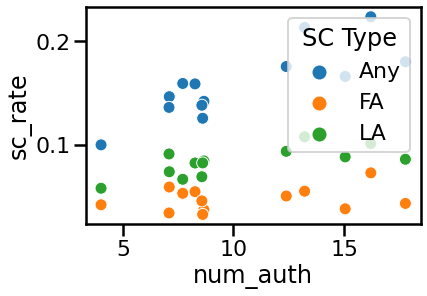

In [87]:
df_topics = df_all[df_all['Year'].isin([2016, 2017, 2018, 2019, 2020])].reset_index(drop=True)
df_topics = df_topics[df_topics['topic']!='Error']
df_topics_summary = df_topics.groupby(['topic', 'SC Type'], as_index=False).agg({'num_auth':'mean', 'numpapers':'sum', 'sc_count':'sum', 'numref':'sum'})
df_topics_summary['topic'] = [int(t) for t in df_topics_summary.topic]
df_topics_summary['sc_rate'] = df_topics_summary['sc_count'] / df_topics_summary['numref']
df_topics_summary = df_topics_summary.sort_values('topic')
topic_names = np.array(['Clinical research', 'Aging & development', 'Dementia', 'Functional imaging',
               'Pain', 'Animal models', 'Stroke', 'Clinical trials', 'Schizophrenia', 'Cellular', 
               'Mechanistic', 'Depression & anxiety', 'Social neuroscience'])
topic_name_dict = dict([(key,value) for key,value in zip(np.arange(len(topic_names)), topic_names)])
df_topics_summary['topic'] = df_topics_summary['topic'].replace(topic_name_dict)
df_topics_summary[df_topics_summary['SC Type']=='FA']
sns.scatterplot(data=df_topics_summary, x='num_auth', y='sc_rate', hue='SC Type')

In [88]:
from scipy.stats import spearmanr

for auth_type in ['FA', 'LA', 'Any']:
  r, p = spearmanr(np.array(df_topics_summary[df_topics_summary['SC Type']==auth_type].num_auth), np.array(df_topics_summary[df_topics_summary['SC Type']==auth_type].sc_rate))
  print(auth_type + "Spearman's r={:.6f}, p={:.6f}".format( r, p ) )

FASpearman's r=0.148352, p=0.628609
LASpearman's r=0.664835, p=0.013166
AnySpearman's r=0.774725, p=0.001871


# new analysis with 7 topics (SI)

In [89]:
df_topic7 = pd.read_csv('/content/gdrive/MyDrive/MINDS_lab/self_citation/notebooks/topic_model/lda_results_7.csv')
topic7_dict = df_topic7.set_index('Title').to_dict()['topic']

In [90]:
topic7 = np.zeros((len(df_all), ))
for i in tqdm(range(len(df_all))):
  title_tmp = df_all.iloc[i]['Title']
  if title_tmp in topic7_dict:
    topic7[i] = topic7_dict[title_tmp]
  else:
    topic7[i] = np.nan

100%|██████████| 470895/470895 [01:32<00:00, 5079.35it/s]


In [91]:
df_all['topic7'] = topic7

In [ ]:
nboot = 1000
unique_titles = list(df_all['Title'].unique())



# Figure 4 - topics
num_topics = 7
topic_fa_sc = np.zeros((nboot, num_topics))
topic_la_sc = np.zeros((nboot, num_topics))
topic_any_sc = np.zeros((nboot, num_topics))

# main boostrap loop
for seed in tqdm(range(nboot)):

  # bootstrap on titles
  np.random.seed(seed)
  titles_boot = np.random.choice(unique_titles, size=len(unique_titles), replace=True)
  df_boot = df_all[df_all['Title'].isin(titles_boot)].reset_index()


  ########################### Topics (include only last 5 years: 2016-2020) ###################################

  df_topics = df_boot[df_boot['Year'].isin([2016, 2017, 2018, 2019, 2020])].reset_index(drop=True)
  df_topics = df_topics[df_topics['topic7']!='Error']

  df_topic_grouped = df_topics.groupby(["topic7", "SC Type"]).agg({"numref": "sum", "sc_count":"sum"}).reset_index()
  df_topic_grouped['sc_rate'] = df_topic_grouped['sc_count'] / df_topic_grouped['numref']
  df_topic_grouped['topic7'] = [int(t) for t in df_topic_grouped.topic7]
  df_topic_grouped = df_topic_grouped.sort_values('topic7')

  topic_fa_sc[seed, :] = df_topic_grouped[df_topic_grouped['SC Type']=='FA']['sc_rate']
  topic_la_sc[seed, :] = df_topic_grouped[df_topic_grouped['SC Type']=='LA']['sc_rate']
  topic_any_sc[seed, :] = df_topic_grouped[df_topic_grouped['SC Type']=='Any']['sc_rate']


########################### Save ###################################
np.savez('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/bootstrap_results/boot_results_topic7.npz', 
         topic_fa_sc=topic_fa_sc, topic_la_sc=topic_la_sc, topic_any_sc=topic_any_sc,
         allow_pickle=True)



100%|██████████| 1000/1000 [18:05<00:00,  1.09s/it]


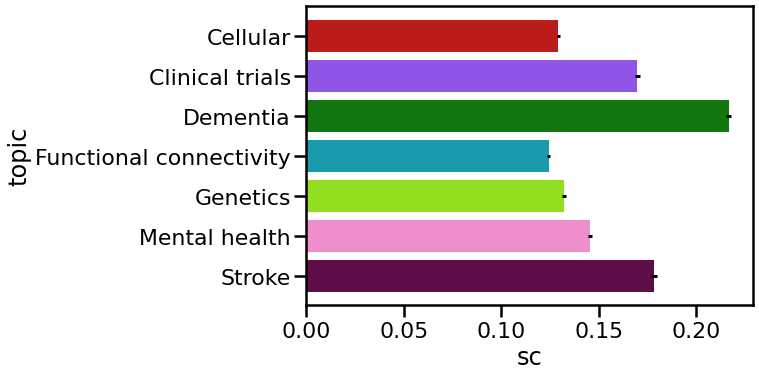

In [92]:
author_type = 'Any'
num_topics = 7
from seaborn.utils import ci
import colorcet as cc

# functions for finding quantiles from dataframes
def qlower(x):
    return x.quantile(0.25)
def qupper(x):
    return x.quantile(0.75)

dat = np.load('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/bootstrap_results/boot_results_topic7.npz')

topic_fa_sc=dat['topic_fa_sc']
topic_la_sc=dat['topic_la_sc']
topic_any_sc=dat['topic_any_sc']

topic_names = np.array(['Mental health', 'Clinical trials', 'Dementia', 'Cellular', 'Stroke', 'Functional connectivity', 'Genetics'])
alphabetical_order = np.argsort(topic_names)
ntopics = len(topic_names)

topic_sc_array = np.array([])
auth_array = np.array([])
topic_id_array = np.array([])
num_boot_iters = np.shape(topic_fa_sc)[0]
for i in range(ntopics):
  topic_sc_array = np.concatenate([topic_sc_array, topic_fa_sc[:, i], topic_la_sc[:, i], topic_any_sc[:, i]])
  auth_array = np.concatenate([auth_array, num_boot_iters*['FA'], num_boot_iters*['LA'], num_boot_iters*['Any']])
  # topic_id_array = np.concatenate([topic_id_array, 3*num_boot_iters*[i]])
  topic_id_array = np.concatenate([topic_id_array, 3*num_boot_iters*[topic_names[i]]])

df_topics = pd.DataFrame({'topic':topic_id_array, 'auth':auth_array, 'sc':topic_sc_array})
df_topics = df_topics.sort_values('topic')

fig, ax = plt.subplots(figsize=(8, 5.5))
many_palette = sns.color_palette(cc.glasbey, n_colors=num_topics)
sns.barplot(data=df_topics[df_topics['auth']==author_type], y='topic', x='sc', ci=None, orient='h', ax=ax, palette=many_palette)

# get quantiles for CI, then add error bars
df_quantiles = df_topics[df_topics.auth==author_type].groupby(['topic']).agg({'sc': [qlower, qupper]})
df_mean = df_topics[df_topics.auth==author_type].groupby(['topic']).agg({'sc': 'mean'})
ci_vals = np.zeros((2, num_topics))
ci_vals[0, :] = np.abs(df_quantiles['sc']['qlower'] - df_mean['sc'])
ci_vals[1, :] = df_quantiles['sc']['qupper'] - df_mean['sc']
ax.errorbar(x=df_mean.sc, y=np.arange(0, num_topics), xerr=ci_vals, ls='', lw=3, color='black')


fig.savefig(base_path + 'fig4_topics/topics_' + str(num_topics) + '_' + author_type + '.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')

# Single journal plot

In [93]:
print(df_all['Source title'].unique())

['Journal of Pineal Research' 'Frontiers in Neuroendocrinology'
 'Annals of Neurology' 'Brain' 'Journal of Neuroinflammation'
 'Behavioral and Brain Sciences' 'Annual Review of Neuroscience'
 'Acta Neuropathologica' 'Brain Stimulation' 'Nature Neuroscience'
 'Neuron' 'Nature Human Behaviour' 'Nature Reviews Neuroscience'
 'Neurology: Neuroimmunology and NeuroInflammation'
 'Progress in Neurobiology' 'Neuroscience and Biobehavioral Reviews'
 'Molecular Neurodegeneration' 'Neuropathology and Applied Neurobiology'
 "npj Parkinson's Disease" 'Trends in Cognitive Sciences'
 'Trends in Neurosciences' 'Sleep Medicine Reviews'
 'Biological Psychiatry' 'Addiction' 'Acta Psychiatrica Scandinavica'
 'American Journal of Psychiatry' 'Body Image' 'JAMA Psychiatry'
 'British Journal of Psychiatry' 'Clinical Psychological Science' 'JAACAP'
 'Brain, Behavior, and Immunity' 'Epidemiology and Psychiatric Sciences'
 'Depression and Anxiety' 'Bipolar Disorders'
 'Evidence-Based Mental Health' 'Schizophren

Correlation between year and self-citation rate for in Neuron for first authors: -0.3226, last authors -0.7442, any authors: -0.4658
Correlation between year and self-citation rate for in Neuron for first authors: -0.9660, last authors -0.8677, any authors: -0.7545


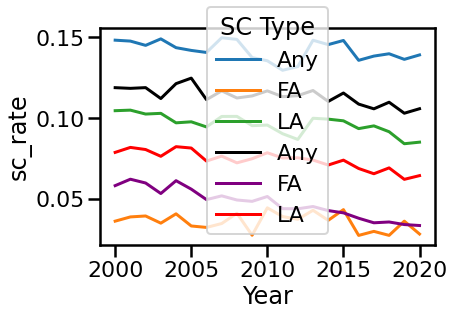

In [94]:
journal_name = 'Neuron'
df_journal = df_all[df_all['Source title']==journal_name]

df_journal_summary = df_journal.groupby(['Year', 'SC Type'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})

df_journal_summary['sc_rate'] = df_journal_summary['sc_count'] / df_journal_summary['numref']
df_journal_summary = df_journal_summary.sort_values('Year')
sns.lineplot(data=df_journal_summary, x='Year', y='sc_rate', hue='SC Type', markers=True, ci=None)

fa_year_corr = np.corrcoef(df_journal_summary[df_journal_summary['SC Type']=='FA'].sc_rate.values, df_journal_summary[df_journal_summary['SC Type']=='FA'].Year.values)[0, 1]
la_year_corr = np.corrcoef(df_journal_summary[df_journal_summary['SC Type']=='LA'].sc_rate.values, df_journal_summary[df_journal_summary['SC Type']=='LA'].Year.values)[0, 1]
any_year_corr = np.corrcoef(df_journal_summary[df_journal_summary['SC Type']=='Any'].sc_rate.values, df_journal_summary[df_journal_summary['SC Type']=='Any'].Year.values)[0, 1]

print('Correlation between year and self-citation rate for in ' + journal_name + ' for first authors: {:.4f}, last authors {:.4f}, any authors: {:.4f}'.format(fa_year_corr, la_year_corr, any_year_corr))



df_journal = df_all[df_all.field=='Neuroscience']

df_journal_summary = df_journal.groupby(['Year', 'SC Type'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})

df_journal_summary['sc_rate'] = df_journal_summary['sc_count'] / df_journal_summary['numref']
df_journal_summary = df_journal_summary.sort_values('Year')
sns.lineplot(data=df_journal_summary, x='Year', y='sc_rate', hue='SC Type', ci=None, markers=True, palette=['black', 'purple', 'red'])

fa_year_corr = np.corrcoef(df_journal_summary[df_journal_summary['SC Type']=='FA'].sc_rate.values, df_journal_summary[df_journal_summary['SC Type']=='FA'].Year.values)[0, 1]
la_year_corr = np.corrcoef(df_journal_summary[df_journal_summary['SC Type']=='LA'].sc_rate.values, df_journal_summary[df_journal_summary['SC Type']=='LA'].Year.values)[0, 1]
any_year_corr = np.corrcoef(df_journal_summary[df_journal_summary['SC Type']=='Any'].sc_rate.values, df_journal_summary[df_journal_summary['SC Type']=='Any'].Year.values)[0, 1]

print('Correlation between year and self-citation rate for in ' + journal_name + ' for first authors: {:.4f}, last authors {:.4f}, any authors: {:.4f}'.format(fa_year_corr, la_year_corr, any_year_corr))

In [ ]:
nboot = 1000
unique_titles = list(df_all['Title'].unique())
journal_name = 'Neuron'

# initialize some bootstrap things
# Descriptive stats - overall, neurology, neuroscience, psychiatry sc rate

# Figure 1 - over time
r_boot_neurology = np.zeros((nboot, 3))
m_boot_neurology = np.zeros((nboot, 3))
r_boot_neuroscience = np.zeros((nboot, 3))
m_boot_neuroscience = np.zeros((nboot, 3))
r_boot_psychiatry = np.zeros((nboot, 3))
m_boot_psychiatry = np.zeros((nboot, 3))
r_boot_journal = np.zeros((nboot, 3))
m_boot_journal = np.zeros((nboot, 3))
sc_rates_neurology = np.zeros((nboot, 21, 3))
sc_rates_neuroscience = np.zeros((nboot, 21, 3))
sc_rates_psychiatry = np.zeros((nboot, 21, 3))
sc_rates_journal = np.zeros((nboot, 21, 3))


# main boostrap loop
for seed in tqdm(range(nboot)):

  # bootstrap on titles
  np.random.seed(seed)
  titles_boot = np.random.choice(unique_titles, size=len(unique_titles), replace=True)
  df_boot = df_all[df_all['Title'].isin(titles_boot)].reset_index()

  ########################### SC Over time - Neurology ###################################
  df_boot_field = df_boot[df_boot.field=='Neurology']
  df_year_sum_all = df_boot_field.groupby(["Year", "SC Type"]).agg({"numref": "sum", "sc_count":"sum"})
  df_year_sum_all['sc_rate'] = df_year_sum_all['sc_count'] / df_year_sum_all['numref']
  df_year_sum_all = df_year_sum_all.sort_values('Year').reset_index()
  df_year_sum_all

  # assign self-citation rates over time
  sc_rates_neurology[seed, :, 0] = df_year_sum_all[df_year_sum_all['SC Type']=='FA']['sc_rate']
  sc_rates_neurology[seed, :, 1] = df_year_sum_all[df_year_sum_all['SC Type']=='LA']['sc_rate']
  sc_rates_neurology[seed, :, 2] = df_year_sum_all[df_year_sum_all['SC Type']=='Any']['sc_rate']

  # calculate correlation (and slope) between year and self-citation rates
  for auth_idx, auth_type in enumerate(['FA', 'LA', 'Any']):
    df_tmp = df_year_sum_all[df_year_sum_all['SC Type']==auth_type]
    r_boot_neurology[seed, auth_idx] = df_tmp['sc_rate'].corr(df_tmp['Year']) 
    regr = linregress(df_tmp['Year'], df_tmp['sc_rate'])
    m_boot_neurology[seed, auth_idx] = regr.slope


  ########################### SC Over time - Neuroscience ###################################
  df_boot_field = df_boot[df_boot.field=='Neuroscience']
  df_year_sum_all = df_boot_field.groupby(["Year", "SC Type"]).agg({"numref": "sum", "sc_count":"sum"})
  df_year_sum_all['sc_rate'] = df_year_sum_all['sc_count'] / df_year_sum_all['numref']
  df_year_sum_all = df_year_sum_all.sort_values('Year').reset_index()
  df_year_sum_all

  # assign self-citation rates over time
  sc_rates_neuroscience[seed, :, 0] = df_year_sum_all[df_year_sum_all['SC Type']=='FA']['sc_rate']
  sc_rates_neuroscience[seed, :, 1] = df_year_sum_all[df_year_sum_all['SC Type']=='LA']['sc_rate']
  sc_rates_neuroscience[seed, :, 2] = df_year_sum_all[df_year_sum_all['SC Type']=='Any']['sc_rate']

  # calculate correlation (and slope) between year and self-citation rates
  for auth_idx, auth_type in enumerate(['FA', 'LA', 'Any']):
    df_tmp = df_year_sum_all[df_year_sum_all['SC Type']==auth_type]
    r_boot_neuroscience[seed, auth_idx] = df_tmp['sc_rate'].corr(df_tmp['Year']) 
    regr = linregress(df_tmp['Year'], df_tmp['sc_rate'])
    m_boot_neuroscience[seed, auth_idx] = regr.slope



  ########################### SC Over time - Psychiatry ###################################
  df_boot_field = df_boot[df_boot.field=='Psychiatry']
  df_year_sum_all = df_boot_field.groupby(["Year", "SC Type"]).agg({"numref": "sum", "sc_count":"sum"})
  df_year_sum_all['sc_rate'] = df_year_sum_all['sc_count'] / df_year_sum_all['numref']
  df_year_sum_all = df_year_sum_all.sort_values('Year').reset_index()
  df_year_sum_all

  # assign self-citation rates over time
  sc_rates_psychiatry[seed, :, 0] = df_year_sum_all[df_year_sum_all['SC Type']=='FA']['sc_rate']
  sc_rates_psychiatry[seed, :, 1] = df_year_sum_all[df_year_sum_all['SC Type']=='LA']['sc_rate']
  sc_rates_psychiatry[seed, :, 2] = df_year_sum_all[df_year_sum_all['SC Type']=='Any']['sc_rate']

  # calculate correlation (and slope) between year and self-citation rates
  for auth_idx, auth_type in enumerate(['FA', 'LA', 'Any']):
    df_tmp = df_year_sum_all[df_year_sum_all['SC Type']==auth_type]
    r_boot_psychiatry[seed, auth_idx] = df_tmp['sc_rate'].corr(df_tmp['Year']) 
    regr = linregress(df_tmp['Year'], df_tmp['sc_rate'])
    m_boot_psychiatry[seed, auth_idx] = regr.slope

  ########################### SC Over time - Journal ###################################
  df_boot_field = df_boot[df_boot['Source title']==journal_name]
  df_year_sum_all = df_boot_field.groupby(["Year", "SC Type"]).agg({"numref": "sum", "sc_count":"sum"})
  df_year_sum_all['sc_rate'] = df_year_sum_all['sc_count'] / df_year_sum_all['numref']
  df_year_sum_all = df_year_sum_all.sort_values('Year').reset_index()
  df_year_sum_all

  # assign self-citation rates over time
  sc_rates_journal[seed, :, 0] = df_year_sum_all[df_year_sum_all['SC Type']=='FA']['sc_rate']
  sc_rates_journal[seed, :, 1] = df_year_sum_all[df_year_sum_all['SC Type']=='LA']['sc_rate']
  sc_rates_journal[seed, :, 2] = df_year_sum_all[df_year_sum_all['SC Type']=='Any']['sc_rate']

  # calculate correlation (and slope) between year and self-citation rates
  for auth_idx, auth_type in enumerate(['FA', 'LA', 'Any']):
    df_tmp = df_year_sum_all[df_year_sum_all['SC Type']==auth_type]
    r_boot_journal[seed, auth_idx] = df_tmp['sc_rate'].corr(df_tmp['Year']) 
    regr = linregress(df_tmp['Year'], df_tmp['sc_rate'])
    m_boot_journal[seed, auth_idx] = regr.slope








df_journal = df_all[df_all.field=='Neuroscience']

df_journal_summary = df_journal.groupby(['Year', 'SC Type'], as_index=False).agg({'sc_count':'sum', 'numref':'sum'})

df_journal_summary['sc_rate'] = df_journal_summary['sc_count'] / df_journal_summary['numref']
df_journal_summary = df_journal_summary.sort_values('Year')
sns.lineplot(data=df_journal_summary, x='Year', y='sc_rate', hue='SC Type', ci=None, markers=True, palette=['black', 'purple', 'red'])

fa_year_corr = np.corrcoef(df_journal_summary[df_journal_summary['SC Type']=='FA'].sc_rate.values, df_journal_summary[df_journal_summary['SC Type']=='FA'].Year.values)[0, 1]
la_year_corr = np.corrcoef(df_journal_summary[df_journal_summary['SC Type']=='LA'].sc_rate.values, df_journal_summary[df_journal_summary['SC Type']=='LA'].Year.values)[0, 1]
any_year_corr = np.corrcoef(df_journal_summary[df_journal_summary['SC Type']=='Any'].sc_rate.values, df_journal_summary[df_journal_summary['SC Type']=='Any'].Year.values)[0, 1]


########################### Save ###################################
np.savez('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/bootstrap_results/boot_results_time.npz', 
         r_boot_neurology = r_boot_neurology, m_boot_neurology = m_boot_neurology, r_boot_neuroscience = r_boot_neuroscience, m_boot_neuroscience = m_boot_neuroscience,
         r_boot_psychiatry = r_boot_psychiatry, m_boot_psychiatry = m_boot_psychiatry, r_boot_journal = r_boot_journal, m_boot_journal = m_boot_journal,
         sc_rates_neurology=sc_rates_neurology, sc_rates_neuroscience=sc_rates_neuroscience, sc_rates_psychiatry=sc_rates_psychiatry, sc_rates_journal=sc_rates_journal,
         allow_pickle=True)



Print out correlation and slope values by field

In [96]:
dat = np.load('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/bootstrap_results/boot_results_time.npz')
print(dat.files)

# r values
print('****r values****')
for field in ['neurology', 'neuroscience', 'psychiatry', 'journal']:

  print(field + ' ' + str(np.mean(dat['r_boot_' + field], axis=0)) )
  print('2.5%' + str(np.percentile(dat['r_boot_' + field], q=2.5, axis=0)) )
  print('97.5%' + str(np.percentile(dat['r_boot_' + field], q=97.5, axis=0)) )

# m values
print('****m values****')
for field in ['neurology', 'neuroscience', 'psychiatry', 'journal']:
  print(field + ' ' + str(100*10*np.mean(dat['m_boot_' + field], axis=0)) )
  print('2.5%' + ' ' + str(100*10*np.percentile(dat['m_boot_' + field], q=2.5, axis=0)) )
  print('97.5%' + ' ' + str(100*10*np.percentile(dat['m_boot_' + field], q=97.5, axis=0)) )

['r_boot_neurology', 'm_boot_neurology', 'r_boot_neuroscience', 'm_boot_neuroscience', 'r_boot_psychiatry', 'm_boot_psychiatry', 'r_boot_journal', 'm_boot_journal', 'sc_rates_neurology', 'sc_rates_neuroscience', 'sc_rates_psychiatry', 'sc_rates_journal', 'allow_pickle']
****r values****
neurology [-0.85412537  0.62516708  0.92692038]
2.5%[-0.91208626  0.48844577  0.89787803]
97.5%[-0.78844704  0.74454783  0.95336663]
neuroscience [-0.95227888 -0.82627795 -0.68662059]
2.5%[-0.97462209 -0.89840934 -0.82127512]
97.5%[-0.92212361 -0.73507102 -0.52788299]
psychiatry [-0.90157027  0.80301634  0.81315965]
2.5%[-0.93452087  0.72635029  0.74267627]
97.5%[-0.86407304  0.86848769  0.87393029]
journal [-0.29539788 -0.65271416 -0.38427644]
2.5%[-0.4661255  -0.79273004 -0.60151549]
97.5%[-0.10528129 -0.47514687 -0.11766674]
****m values****
neurology [-0.58177247  0.37995053  1.79778589]
2.5% [-0.67186878  0.28444342  1.64102138]
97.5% [-0.49676669  0.47179772  1.94907361]
neuroscience [-1.42233902 

Plot by field

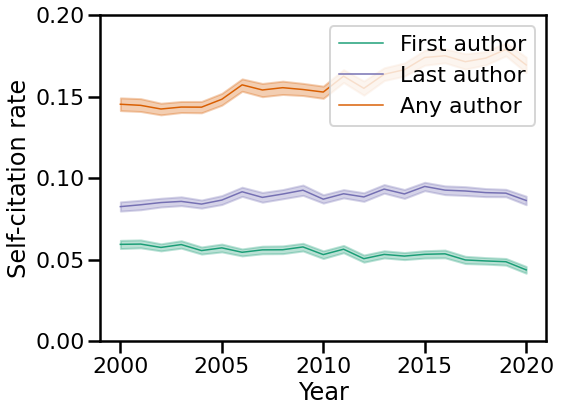

In [97]:
save_figs=True
sns.set_context('poster')
ordering = ['First author', 'Last author', 'Any author']
years = np.arange(2000, 2021)
fig, ax = plt.subplots(figsize=(8, 6)) 
colors = custom_palette[:3]
field = 'neurology'
sc_rates_time = dat['sc_rates_' + field]

for i, sc_type in enumerate(ordering):
  sc_time_iter = np.mean(sc_rates_time[:, :, i], axis=0)  # either first, last or any
  sc_lower = np.percentile(sc_rates_time[:, :, i], q=2.5, axis=0)
  sc_upper = np.percentile(sc_rates_time[:, :, i], q=97.5, axis=0)

  ax.plot(years, sc_time_iter, label=sc_type, color=custom_palette[i], linewidth=1.5)
  ax.fill_between(years, sc_lower, sc_upper, color=custom_palette[i], alpha=.3)

ax.set_xticks([2000, 2005, 2010, 2015, 2020])
ax.set_ylim([0, 0.2])
ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax.set_xlabel('Year')
ax.set_ylabel('Self-citation rate')
plt.legend()

fig.savefig(base_path + 'fig1_time_hist/over_time_' + field + '.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')


Plot journal on top

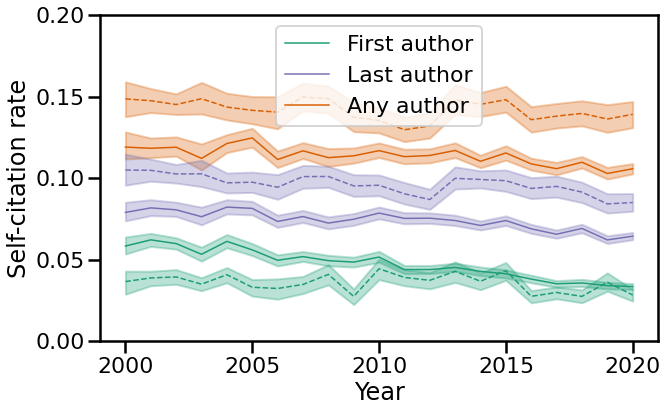

In [98]:
save_figs=True
sns.set_context('poster')
ordering = ['First author', 'Last author', 'Any author']
years = np.arange(2000, 2021)
fig, ax = plt.subplots(figsize=(10, 6)) 
colors = custom_palette[:3]
field = 'neuroscience'
sc_rates_time = dat['sc_rates_' + field]

for i, sc_type in enumerate(ordering):
  sc_time_iter = np.mean(sc_rates_time[:, :, i], axis=0)  # either first, last or any
  sc_lower = np.percentile(sc_rates_time[:, :, i], q=2.5, axis=0)
  sc_upper = np.percentile(sc_rates_time[:, :, i], q=97.5, axis=0)

  ax.plot(years, sc_time_iter, label=sc_type, color=custom_palette[i], linewidth=1.5)
  ax.fill_between(years, sc_lower, sc_upper, color=custom_palette[i], alpha=.3)

ax.set_xticks([2000, 2005, 2010, 2015, 2020])
ax.set_ylim([0, 0.2])
ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax.set_xlabel('Year')
ax.set_ylabel('Self-citation rate')
plt.legend()


field = 'journal'
sc_rates_time = dat['sc_rates_' + field]

for i, sc_type in enumerate(ordering):
  sc_time_iter = np.mean(sc_rates_time[:, :, i], axis=0)  # either first, last or any
  sc_lower = np.percentile(sc_rates_time[:, :, i], q=2.5, axis=0)
  sc_upper = np.percentile(sc_rates_time[:, :, i], q=97.5, axis=0)

  ax.plot(years, sc_time_iter, label=sc_type, color=custom_palette[i], linewidth=1.5, linestyle='dashed')
  ax.fill_between(years, sc_lower, sc_upper, color=custom_palette[i], alpha=.3)

fig.savefig(base_path + 'fig1_time_hist/over_time_neuron_overlay.svg', format="svg", transparent=True, dpi=400, bbox_inches='tight')


Bar plot journal

,Source title,sc_count,numref,sc_rate
0,Annual Review of Neuroscience,1257,17283,0.072730
1,Behavioral and Brain Sciences,1068,21953,0.048649
2,"Brain, Behavior, and Immunity",7198,96191,0.074830
3,Frontiers in Neuroendocrinology,1998,37561,0.053193
4,Journal of Neuroinflammation,7580,96034,0.078930
5,Journal of Pineal Research,2281,25781,0.088476
6,Nature Human Behaviour,1539,21807,0.070574
7,Nature Neuroscience,5126,56068,0.091425
8,Nature Reviews Neuroscience,3309,44225,0.074822
9,Neuron,12364,137268,0.090072


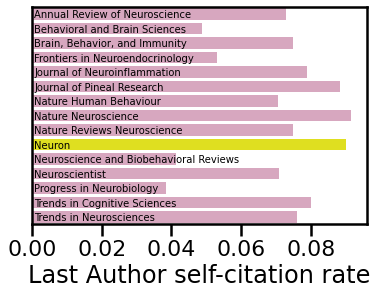

In [99]:
auth_type = 'LA'
df_summary_recent = df_all[ (df_all['SC Type']==auth_type) & (df_all.Year.isin([2016, 2017, 2018, 2019, 2020])) & (df_all.field=='Neuroscience')].groupby('Source title', as_index=False).agg({'sc_count':'sum', 'numref':'sum'})
df_summary_recent['sc_rate'] = df_summary_recent['sc_count'] / df_summary_recent['numref']

fig, ax = plt.subplots()
color_list = len(df_summary_recent)*['#df9fbf']
color_list[9] = 'yellow'

sns.barplot(data=df_summary_recent, y='Source title', x='sc_rate', ax=ax, palette=color_list)
ax.set_yticks([])

rects = ax.patches
labels = ['yee']*len(df_summary_recent)
labels = df_summary_recent['Source title'].unique()
for rect, label in zip(rects, labels):
    height = rect.get_height()
    # ax.text(
    #     rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    # )
    ax.text(
       0.0007, rect.get_y()+.45, label, ha="left", va="center", fontsize=10
    )

if auth_type=='FA':
  ax.set_xlabel('First Author self-citation rate')
elif auth_type=='LA':
  ax.set_xlabel('Last Author self-citation rate')
elif auth_type=='Any':
  ax.set_xlabel('Any Author self-citation rate')

ax.set_ylabel('')

fig.savefig('/content/gdrive/MyDrive/MINDS_lab/self_citation/analysis/figures/cover_letter/' + auth_type + '_journals.png', transparent=True, dpi=400, bbox_inches='tight')
df_summary_recent